In [9]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import math
import pandas as pd
from PIL import Image
import time
import cv2
import seaborn as sns
import cite2c

style.use("seaborn")

## Neural network classification 

Have used the Neural Networks from Scratch in Python (Kinsley & Kukieła, 2020) book for the Neural Network code.

In [10]:
class LayerDense:
    def __init__(self,n_inputs,n_neurons):
        self.weights=0.1*np.random.randn(n_inputs,n_neurons)
        self.biases=np.zeros((1,n_neurons))
    
    def forward(self,inputs):
         self.inputs=inputs
         self.output=np.dot(inputs,self.weights)+self.biases 
            
    def backward(self,dvalues):
        self.dweights= np.dot(self.inputs.T, dvalues)  
        self.dinputs= np.dot(dvalues,self.weights.T)
        self.dbiases= np.sum(dvalues,axis=0,keepdims=True) 

            
class Activation_RELU:
    def forward(self,inputs):
        self.inputs = inputs
        self.output=np.maximum(inputs,0) 
    
    def backward(self,dvalues):
        self.dinputs=dvalues.copy()
        self.dinputs[self.inputs <=0]=0
        
class Activation_softmax:
    def forward(self,inputs):
        exp_values=np.exp(inputs-np.amax(inputs,axis=1,keepdims=True))
        self.output=exp_values/np.sum(exp_values,axis=1,keepdims=True) 
        
    # Backward pass
    def backward ( self , dvalues ):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)
        
        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate ( zip (self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape( - 1 , 1 )
# Calculate Jacobian matrix of the output and
            jacobian_matrix = np.diagflat(single_output) - \
            np.dot(single_output, single_output.T)
# Calculate sample-wise gradient
# and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,
            single_dvalues)
        
# Common loss class       
class Loss :
    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate ( self , output , y ):
        # Calculate sample losses
        sample_losses = self.forward(output, y)
        # Calculate mean loss
        data_loss = np.mean(sample_losses)
        # Return loss
        return data_loss

# Cross-entropy loss
class Loss_CategoricalCrossentropy ( Loss ):
    
    # Forward pass
    def forward ( self , y_pred , y_true ):
        # Number of samples in a batch
        samples = len (y_pred)
        
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7 , 1 - 1e-7 )
        
        # Probabilities for target values -
        # only if categorical labels
        if len (y_true.shape) == 1 :
            correct_confidences = y_pred_clipped[range (samples),y_true]
        
        # Mask values - only for one-hot encoded labels
        elif len (y_true.shape) == 2 :
            correct_confidences = np.sum(y_pred_clipped * y_true,axis = 1)
            
        # Losses
        negative_log_likelihoods = - np.log(correct_confidences)
        return negative_log_likelihoods
    
    # Backward pass
    def backward(self,dvalues,y_true):
        
        # Number of samples
        samples=len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels=len(dvalues[0])
        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape)==1:
            y_true=np.eye(labels)[y_true]
        # Calculate gradient
        self.dinputs=-y_true/dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples

        
# Softmax classifier - combined Softmax activation  and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy ():
    # Creates activation and loss function objects
    def __init__ ( self ):
        self.activation = Activation_softmax()
        self.loss = Loss_CategoricalCrossentropy()
        
    # Forward pass
    def forward ( self , inputs , y_true ):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)
    
    # Backward pass
    def backward ( self , dvalues , y_true ):
        # Number of samples
        samples = len (dvalues)
        
        # If labels are one-hot encoded,
        # turn them into discrete values
        if len (y_true.shape) == 2 :
            y_true = np.argmax(y_true, axis = 1)
       
        # Copy so we can safely modify    
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[ range (samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples   
        

class Optimizer_Adam :
    # Initialize optimizer - set settings
    def __init__ ( self , learning_rate = 0.001 , decay = 0. , epsilon = 1e-7 , beta_1 = 0.9 , beta_2 = 0.999 ):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        
    # Call once before any parameter updates
    def pre_update_params ( self ):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                                        ( 1. / ( 1. + self.decay * self.iterations))
            
    # Update parameters
    def update_params ( self , layer ):
        # If layer does not contain cache arrays,create them filled with zeros
        if not hasattr (layer, 'weight_cache' ):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
        
        # Update momentum with current gradients
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + ( 1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + ( 1 - self.beta_1) * layer.dbiases
    
        # Get corrected momentum, self.iteration is 0 at first pass
        # and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / \
                                ( 1 - self.beta_1 ** (self.iterations + 1 ))
        bias_momentums_corrected = layer.bias_momentums / \
                                ( 1 - self.beta_1 ** (self.iterations + 1 ))
        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + ( 1 - self.beta_2) * layer.dweights ** 2
        layer.bias_cache = self.beta_2 * layer.bias_cache + ( 1 - self.beta_2) * layer.dbiases ** 2

        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / \
                            ( 1 - self.beta_2 ** (self.iterations + 1 ))
        bias_cache_corrected = layer.bias_cache / \
                            ( 1 - self.beta_2 ** (self.iterations + 1 ))
    
        # Vanilla SGD parameter update + normalization with square rooted cache
        layer.weights += - self.current_learning_rate * weight_momentums_corrected / \
                        (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += - self.current_learning_rate * bias_momentums_corrected / \
                        (np.sqrt(bias_cache_corrected) + self.epsilon)
    
    # Call once after any parameter updates
    def post_update_params ( self ):
        self.iterations += 1

#### Selecting the Booleaen functions

In [6]:
#Default functions
func1= 'X&Y&Z'
func2= 'X|Y|Z' 
func3='X&(not(Y))&Z'
func4='X|(not(Y))&Z'
func5='(not(X&Y))|Z'

In [7]:
#Taking boolean functions from user
func1=input("""Enter the first three variable (X,Y,Z) boolean function.
            Use & : AND gate,  | : OR gate,  not(): NOT gate.
             Example - X & (not(Y)) | Z : """)
func2=input("Enter the second three variable (X,Y,Z) boolean function: ")
func3=input("Enter the third three variable (X,Y,Z) boolean function: ")
func4=input("Enter the fourth three variable (X,Y,Z) boolean function: ")
func5=input("Enter the fifth three variable (X,Y,Z) boolean function: ")

Enter the first three variable (X,Y,Z) boolean function.
            Use & : AND gate,  | : OR gate,  not(): NOT gate.
             Example - X & (not(Y)) | Z : (not(X))&Y&Z
Enter the second three variable (X,Y,Z) boolean function: X|((not(Y))&Z)
Enter the third three variable (X,Y,Z) boolean function: X|Y|Z
Enter the fourth three variable (X,Y,Z) boolean function: X|Y&(not(Z))
Enter the fifth three variable (X,Y,Z) boolean function: X|(Y&Z)


#### Generating training examples for the Boolean functions

In [11]:
function1_op=[]
function2_op=[]
function3_op=[]
function4_op=[]
function5_op=[]
input1=[]
input2=[]
input3=[]

for X in range (2):
    for Y in range (2):
        for Z in range (2):
            input1.append(X)   #first variable X
            input2.append(Y)   #second variable Y
            input3.append(Z)   #third variable Z
            function1_op.append(eval(func1))  #Evaluating the functions
            function2_op.append(eval(func2))
            function3_op.append(eval(func3))
            function4_op.append(eval(func4))
            function5_op.append(eval(func5))
            
input1=input1*5
input2=input2*5
input3=input3*5
functions_op=np.concatenate((function1_op, function2_op, function3_op, function4_op, function5_op))
temp=[]
for i in range(1,6):
    temp.append([i]*8)
function_no=np.array(sum(temp,[])) #identiying each function by a number

In [12]:
data = {'inp1':input1,
        'inp2':input2,
        'inp3':input3,
        'func_no':function_no,
        'output':functions_op,}
 
df = pd.DataFrame(data)
 
# Dataframe of the inputs and outputs
print(df[['func_no','inp1', 'inp2','inp3','output']]) 

    func_no  inp1  inp2  inp3  output
0         1     0     0     0       0
1         1     0     0     1       0
2         1     0     1     0       0
3         1     0     1     1       1
4         1     1     0     0       0
5         1     1     0     1       0
6         1     1     1     0       0
7         1     1     1     1       0
8         2     0     0     0       0
9         2     0     0     1       1
10        2     0     1     0       0
11        2     0     1     1       0
12        2     1     0     0       1
13        2     1     0     1       1
14        2     1     1     0       1
15        2     1     1     1       1
16        3     0     0     0       0
17        3     0     0     1       1
18        3     0     1     0       1
19        3     0     1     1       1
20        3     1     0     0       1
21        3     1     0     1       1
22        3     1     1     0       1
23        3     1     1     1       1
24        4     0     0     0       0
25        4 

#### Training

In [15]:
#inputs
X=np.dstack((function_no,input1, input2,input3))[0]
#outputs
y=np.array(functions_op)
layer1=LayerDense(4,60) #hidden layer
activation1=Activation_RELU()
layer2=LayerDense(60,2) #output layer
loss_function = Activation_Softmax_Loss_CategoricalCrossentropy()
optimiser=Optimizer_Adam(learning_rate = 0.02, decay = 1e-5 )

In [16]:
for epoch in range(10001):
    #forward pass
    layer1.forward(X)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    loss=loss_function.forward(layer2.output,y)
    
    predictions = np.argmax(loss_function.output, axis = 1 )
    accuracy = np.mean(predictions == y)
        
    if not epoch % 1000 :
        print ('epoch:',epoch , 'acc:', round(accuracy,3) , 'loss:', round(loss,6) ,'lr:', optimiser.current_learning_rate)
    
    #back propogation
    loss_function.backward(loss_function.output,y)
    layer2.backward(loss_function.dinputs)
    activation1.backward(layer2.dinputs)
    layer1.backward(activation1.dinputs)
    
    optimiser.pre_update_params()
    optimiser.update_params(layer1)
    optimiser.update_params(layer2)
    optimiser.post_update_params()
    

epoch: 0 acc: 0.425 loss: 0.723614 lr: 0.02
epoch: 1000 acc: 0.975 loss: 0.049139 lr: 0.019802176259170884
epoch: 2000 acc: 0.975 loss: 0.04805 lr: 0.019608035372895814
epoch: 3000 acc: 0.975 loss: 0.047916 lr: 0.01941766424916747
epoch: 4000 acc: 0.975 loss: 0.047802 lr: 0.019230954143789846
epoch: 5000 acc: 1.0 loss: 0.010975 lr: 0.01904780045524243
epoch: 6000 acc: 1.0 loss: 0.000221 lr: 0.018868102529269144
epoch: 7000 acc: 1.0 loss: 7.7e-05 lr: 0.018691763474424996
epoch: 8000 acc: 1.0 loss: 3.5e-05 lr: 0.01851868998787026
epoch: 9000 acc: 1.0 loss: 1.8e-05 lr: 0.018348792190754044
epoch: 10000 acc: 1.0 loss: 1e-05 lr: 0.018181983472577025


#### Testing

In [17]:
temp=np.random.randint(40,size=10)
X_test=[]
y_test=[]
for i in temp:
    X_test.append(X[i])
    y_test.append(y[i])
X_test=np.array(X_test)
y_test=np.array(y_test)
print(f'X_test={X_test}')
print(f'y_test={y_test}')

X_test=[[2 1 0 0]
 [3 1 1 1]
 [3 0 0 1]
 [1 1 1 0]
 [5 0 1 1]
 [1 1 0 1]
 [3 1 1 0]
 [1 0 0 0]
 [5 0 1 0]
 [2 0 0 1]]
y_test=[1 1 1 0 1 0 1 0 0 1]


In [18]:
layer1.forward(X_test)
activation1.forward(layer1.output)
layer2.forward(activation1.output)
loss=loss_function.forward(layer2.output,y_test)
#print(activation2.output[:5],y[:5])
    
predictions = np.argmax(loss_function.output, axis = 1 )
accuracy = np.mean(predictions == y_test)

print(f'predictions={predictions}')
print(f'accuracy={accuracy}')

predictions=[1 1 1 0 1 0 1 0 0 1]
accuracy=1.0


# Q-learning 

Have used pythonprogramming.net(Kinsley, 2021) and Deep Lizard's("Q-Learning Explained", 2021) reinforcement learning courses as references. 

In [19]:
def generate_frozen_lake(SIZE,holes, print_holes=False):

    occupied_squares=[]
#Player starting point
    player_x=0
    player_y=0
    occupied_squares.append((player_x,player_y))

#Goal starting point
    goal_x=SIZE-1
    goal_y=SIZE-1
    occupied_squares.append((goal_x,goal_y))

#Holes starting point
    hole_list=[]
    while len(hole_list)<holes:
        hole_x=np.random.randint(0, SIZE)
        hole_y=np.random.randint(0, SIZE)
        if (hole_x,hole_y) not in occupied_squares:
            occupied_squares.append((hole_x,hole_y))
            hole_list.append((hole_x,hole_y))
    if print_holes==True:
       print(f'holes: {hole_list}')

#initialised q table
    q_table = np.zeros((SIZE**2, 4))

    return hole_list, q_table

In [20]:
def move(x,y,choice,SIZE):
 
        new_x= 100
        new_y= 100
        
        done=False
        
        while done==False:
            if choice == 0:   #move up
                new_x=x
                new_y=y+1
            elif choice == 1: #move down
                new_x=x
                new_y=y-1
            elif choice == 2: #move right
                new_x=x+1
                new_y=y
            elif choice == 3: #move left
                new_x=x-1
                new_y=y
            else:
                print("Incorrect choice")
            
        
           # If we are out of bounds, fix!
            if new_x >= 0 and new_x <= SIZE-1 and new_y >= 0 and new_y <= SIZE-1:
                done=True
            else:
                choice=np.random.randint(0,4)
                
        return new_x,new_y,choice

In [21]:
def display_env(SIZE,hole_list):
    
    goal_x=SIZE-1
    goal_y=SIZE-1
    player_x = 0
    player_y = 0
    
    d = {1: (255, 175, 0),  #player is orange
         2: (0, 255, 0),    #hole is blue
         3: (0, 0, 255)}    #goal is green

    PLAYER_N = 1  # player key in dict
    GOAL_N = 2  # food key in dict
    HOLE_N = 3  # enemy key in dict

    env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)  # starts an rbg of our size
    env[goal_x][goal_y] = d[GOAL_N]  # sets the goal location tile to green color
    env[player_x][player_y] = d[PLAYER_N]  # sets the player tile to orange
    for hole_x,hole_y in hole_list:
        env[hole_y][hole_x] = d[HOLE_N]# sets the hole location to blue
    img = Image.fromarray(np.flipud(env), 'RGB')  # reading to rgb. 
    img = img.resize((SIZE, SIZE))  # resizing 
    plt.imshow(img) # show it!

In [25]:
def frozen_lake( holes, SIZE, LEARNING_RATE=0.55, DISCOUNT=0.6, player_x=0, player_y=0, 
                hole_list=[], display=True, generate=True):
    
    if generate==True:
        hole_list, q_table=generate_frozen_lake(SIZE,holes)
        goal_x=goal_y=SIZE-1
    if generate==False:
        q_table = np.zeros((SIZE**2, 4))
        goal_x=goal_y=SIZE-1
    
    if display==True:
        display_env(SIZE,hole_list)
    
    total_reward_list=[]
    HOLE_PENALTY = 100
    GOAL_REWARD = 200
    epsilon = 0.9
    EPS_DECAY = 0.9998
    
    step=0
    episode=0
    total_episodes=10000
    max_steps_per_episode=(SIZE**2)*3

    for episode in range(total_episodes):
    
        player_x=0
        player_y=0
        state=player_x+(player_y*SIZE)
        reward=0
        total_reward=0
        done=False
        
    
        for step in range(max_steps_per_episode):
       
            # Selecting action
            # Exploration-exploitation trade-off
            if np.random.random() > epsilon:
                # GET THE ACTION
                choice = np.argmax(q_table[state,:])
            else:
                # Take the action!
                choice = np.random.randint(0, 4) 
        
            player_x,player_y, action = move(player_x,player_y,choice,SIZE)

            if player_x == goal_x and player_y == goal_y:
                reward = GOAL_REWARD
                done=True  #program is terminated if player reaches the goal
            else:
                reward=0
        
            for hole in hole_list:
                if(player_x,player_y)==hole:
                    reward = -HOLE_PENALTY    #program is not terminated if player falls in hole
                    break
  

            new_state=player_x+(player_y*SIZE)
            max_future_q = np.max(q_table[new_state])
            current_q = q_table[state][action]

            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)  
            q_table[state][action] = new_q
            state=new_state
            total_reward+=reward
        
            if done==True:
                break
    
        epsilon *= EPS_DECAY
        total_reward_list.append(total_reward) 

   

    return total_reward_list, q_table


#### Generating the frozen lake

In [26]:
SIZE=int(input('Enter the size of the lake:'))
done=False
while done==False:
    holes=int(input('Enter the number of holes:'))
    if holes>(SIZE**2-2):
        print('Error, too many holes')
    else:
        done=True

Enter the size of the lake:4
Enter the number of holes:4


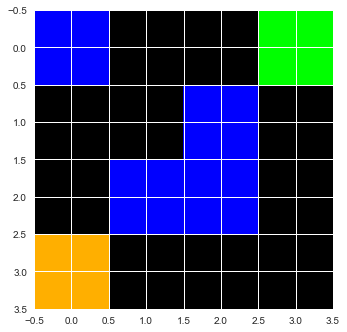

In [27]:
total_reward_list, q_table=frozen_lake(holes, SIZE)

#### Finding the path

In [28]:
#Path to the goal
np.flipud(np.argmax(q_table,axis=1).reshape(SIZE,SIZE))
#0:move up, 1: move down, 2: move right, 3: move left

array([[2, 2, 2, 0],
       [2, 0, 0, 0],
       [0, 0, 2, 0],
       [0, 2, 2, 0]], dtype=int64)

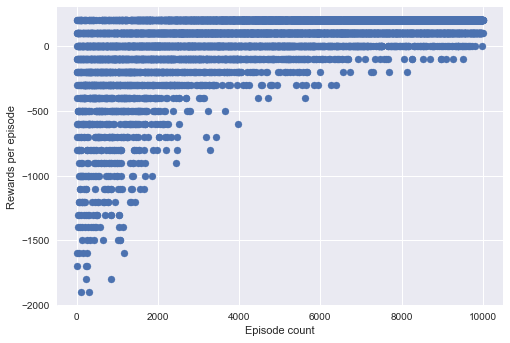

In [29]:
plt.scatter(np.linspace(0,len(total_reward_list),len(total_reward_list)),total_reward_list)
plt.ylabel("Rewards per episode")
plt.xlabel("Episode count")
plt.show()

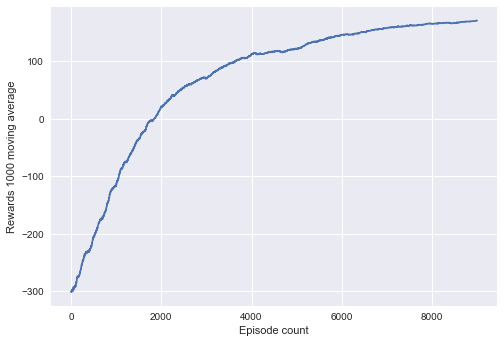

In [30]:
moving_avg = np.convolve(total_reward_list, np.ones((1000,))/1000, mode='valid')

plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel("Rewards 1000 moving average")
plt.xlabel("Episode count")
plt.show()

#### Changing learning and discount rates  

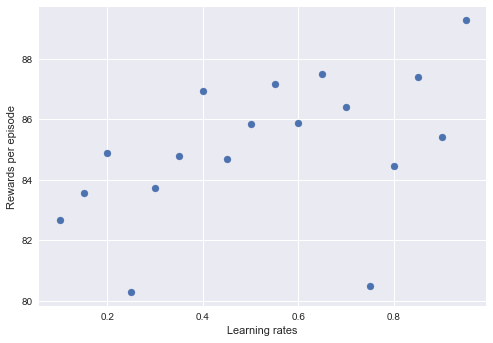

In [32]:
learning_rewards=[]
learning_rates=[]
LEARNING_RATE=0.1
hole_list, qtable=generate_frozen_lake(SIZE,holes) #creating a standard environment to prevent a new environment being
                                                    # generated on every iteration
while LEARNING_RATE<1:
    total_reward, q_table=frozen_lake(holes, SIZE, LEARNING_RATE=LEARNING_RATE,hole_list=hole_list,display=False,generate=False)
    learning_rewards.append(sum(total_reward)/len(total_reward))
    learning_rates.append(LEARNING_RATE)
    LEARNING_RATE+=0.05

plt.scatter(learning_rates,learning_rewards)
plt.xlabel("Learning rates")
plt.ylabel("Rewards per episode")
plt.show()

There is no consistent pattern in the rewards as a function of learning rates. The optimal rate fluctuates with every environment.

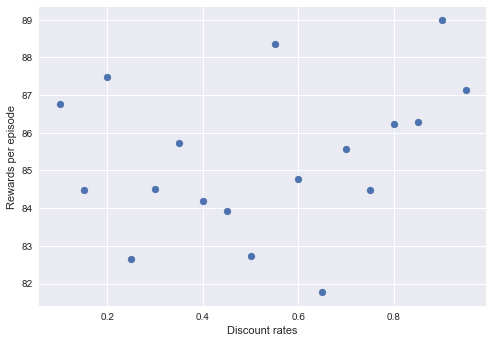

In [33]:
discount_rewards=[]
discount_rates=[]
DISCOUNT=0.1
while DISCOUNT<1:
    total_reward, q_table=frozen_lake(holes, SIZE, DISCOUNT=DISCOUNT,hole_list=hole_list,display=False,generate=False)
    discount_rewards.append(sum(total_reward)/len(total_reward))
    discount_rates.append(DISCOUNT)
    DISCOUNT+=0.05
    
plt.scatter(discount_rates,discount_rewards)
plt.xlabel("Discount rates")
plt.ylabel("Rewards per episode")
plt.show()

The same pattern is seen with temporal discounting rates. The optimal rate fluctuates with every environment.

#### Changing size of lake and number of holes

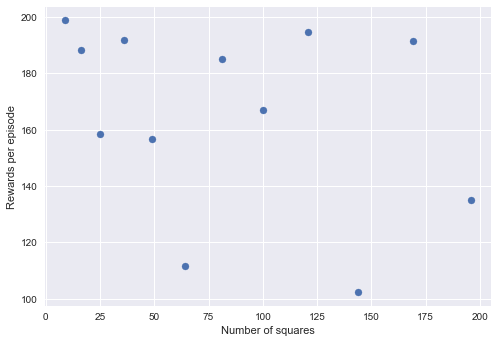

In [36]:
SIZE_rewards=[]
SIZE_rates=[]
for SIZE in range(3,15):
    holes=int(SIZE/4)
    total_reward, q_table=frozen_lake(holes, SIZE, display=False)
    SIZE_rewards.append(sum(total_reward)/len(total_reward))
    SIZE_rates.append(SIZE**2)

plt.scatter(SIZE_rates,SIZE_rewards)
plt.xlabel("Number of squares")
plt.ylabel("Rewards per episode")
plt.show()

The average reward per episode does not vary with the size of the environment provided that the number of holes in the environment increases proportionally.

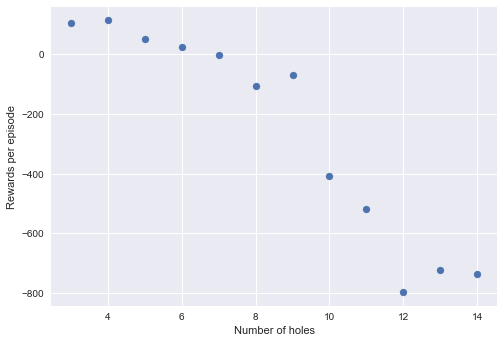

In [37]:
SIZE=5
holes_rewards=[]
holes_rates=[]
for holes in range(3,15):
    total_reward, q_table=frozen_lake(holes, SIZE, display=False)
    holes_rewards.append(sum(total_reward)/len(total_reward))
    holes_rates.append(holes)
    
plt.scatter(holes_rates,holes_rewards)
plt.xlabel("Number of holes")
plt.ylabel("Rewards per episode")
plt.show()

The average reward per episode decreases as the number of holes in the environment increases. This is intuitive as we expect the agent to find it more difficult as the number of holes increase.

## Rulkov map

Have used Rulkov's paper (Rulkov, 2002) as reference for the model and the Data-Driven Science and Engineering (Brunton & Kutz, 2019) book as reference for the fourier transformation process.

In [44]:
def f(x,y,alpha):
    if x<=0:
        return (alpha/(1-x))+y
    elif 0<x<(alpha+y):
        return alpha+y
    elif x>=(alpha+y):
        return -1

In [45]:
def neuron_potential(sigma_list, alpha, x=0, y=-3, mu=0.001):
    
    x_list=[]
    for sigma in sigma_list:
        for n in range (2000):
        
          x_new=f(x,y,alpha)
          y_new=y-mu*(x+1)+mu*sigma
    
          x_list.append(x_new)
 
          x=x_new
          y=y_new
        
    return x_list,n+1

#### Plotting neuron behaviour

Text(0.5, 1.0, 'Tonic spiking, sigma=0.1')

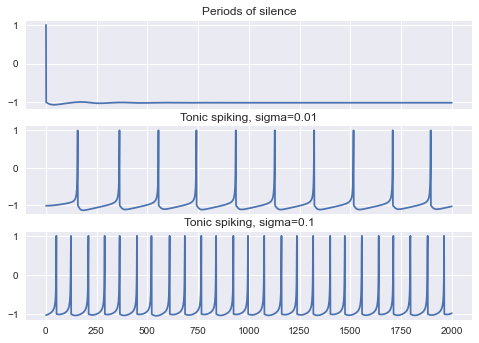

In [46]:
x_list,n=neuron_potential(sigma_list=[-0.01,0.01,0.1], alpha=4)

fix,axs=plt.subplots(3,1, sharex=True)
plt.sca(axs[0])
plt.plot(np.linspace(1,n,n),x_list[0:n])
plt.title('Periods of silence')

plt.sca(axs[1])
plt.plot(np.linspace(1,n,n),x_list[n:2*n])
plt.title('Tonic spiking, sigma=0.01')

plt.sca(axs[2])
plt.plot(np.linspace(1,n,n),x_list[2*n:])
plt.title('Tonic spiking, sigma=0.1')

Text(0.5, 1.0, 'Bursts of spiking, sigma=0.386, alpha=6')

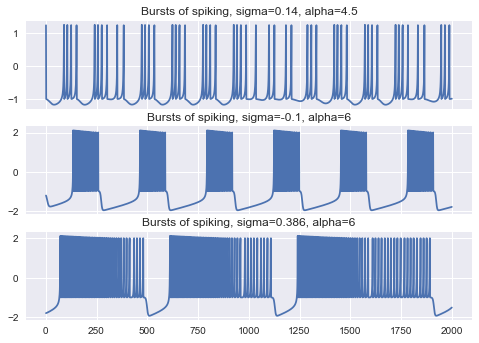

In [47]:
x_list,n=neuron_potential(sigma_list=[0.14], alpha=4.5, x=0, y=-3.25)

fix,axs=plt.subplots(3,1, sharex=True)
plt.sca(axs[0])
plt.plot(np.linspace(1,n,n),x_list)
plt.title('Bursts of spiking, sigma=0.14, alpha=4.5')

x_list,n=neuron_potential(sigma_list=[-0.1,0.386], alpha=6, x=-1.2, y=-3.95)
plt.sca(axs[1])
plt.plot(np.linspace(1,n,n),x_list[0:n])
plt.title('Bursts of spiking, sigma=-0.1, alpha=6')

plt.sca(axs[2])
plt.plot(np.linspace(1,n,n),x_list[n:])
plt.title('Bursts of spiking, sigma=0.386, alpha=6')

#### Categorising signals using fast fourier transformation

In [48]:
def compute_FFT(x_list,n, return_var=False, display=True ):
    fhat=np.fft.fft(x_list,n) #Compute FFT
    PSD= fhat*np.conj(fhat)/n #Power spectrum (power per frequency)
    dt=0.001
    freq=(1/(dt*n)) * np.arange(n)
    L = np.arange(1,np.floor(n/2),dtype='int')
    
    if display==True:
        plt.figure()
        plt.plot(np.linspace(0,n,n+1),x_list)
        plt.title('Original Signal')
        plt.show()

        plt.figure()
        plt.plot(freq[L],PSD[L])
        plt.xlim(freq[L[0]],freq[L[-1]])
        plt.title('Fourier Transformation')
        plt.show()
    
    
        print(f'maximum PSD={max(PSD[L])}')
        arg=np.argmax(PSD[L])
        print(f'argmax PSD={np.argmax(PSD[L])}')
        print(f'maximum frequency={freq[L][arg]}')
    
    if return_var==True:
        return freq, PSD, L

##### Periods of silence

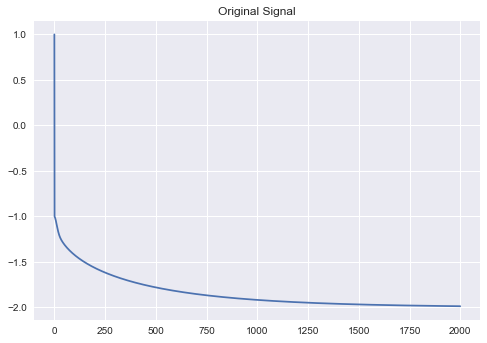

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


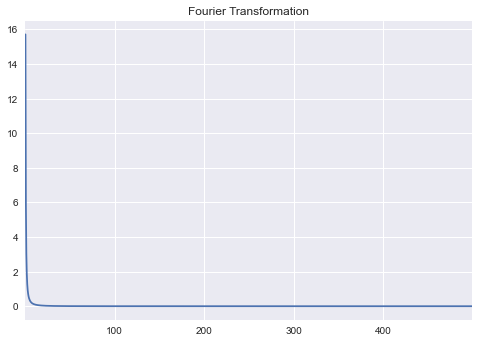

maximum PSD=(15.716030741305453+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


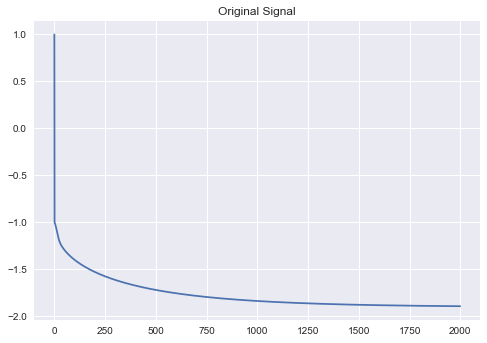

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


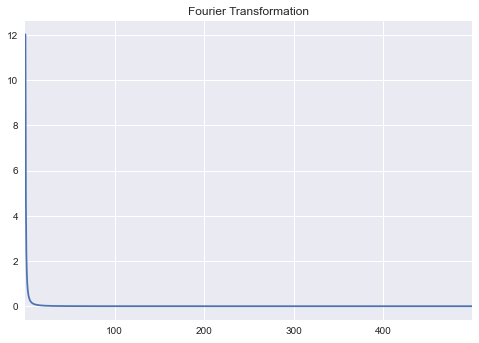

maximum PSD=(12.016799190856506+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


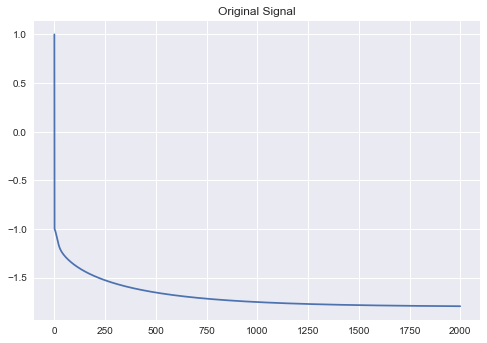

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


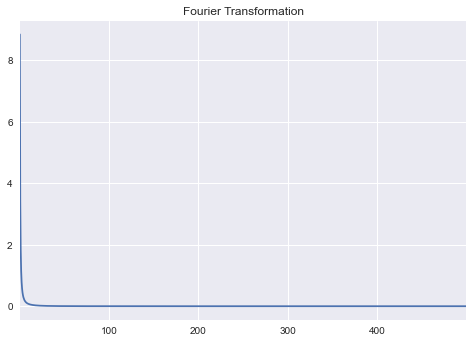

maximum PSD=(8.845191436044013+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


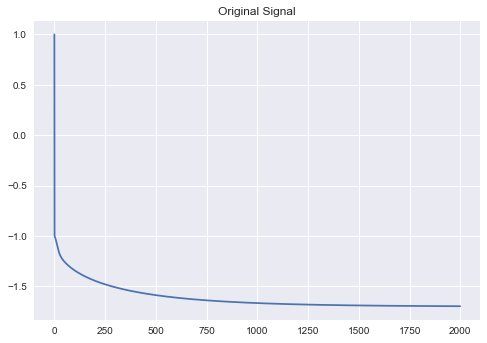

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


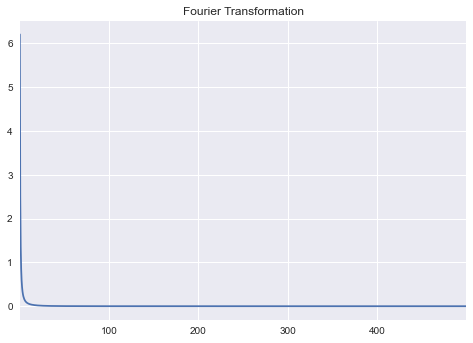

maximum PSD=(6.193842930197501+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


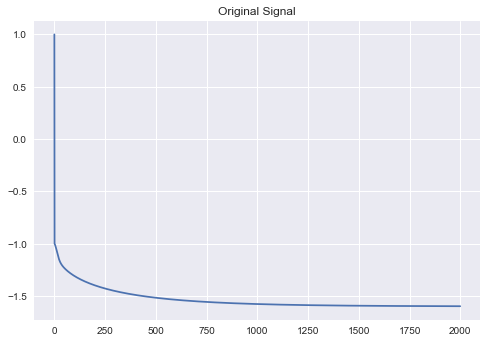

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


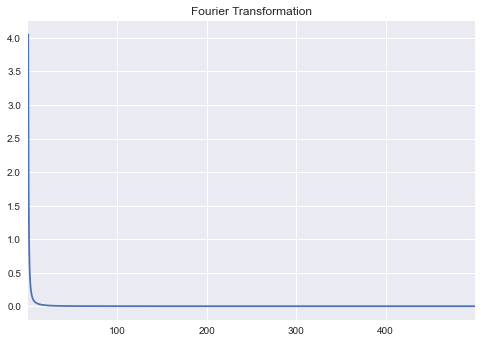

maximum PSD=(4.05254622793673+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


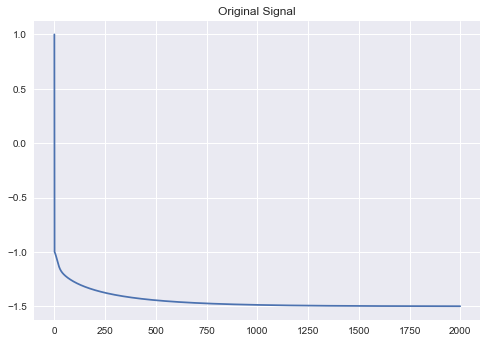

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


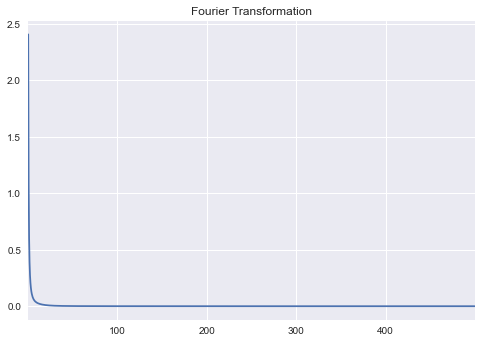

maximum PSD=(2.4062815874912062+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


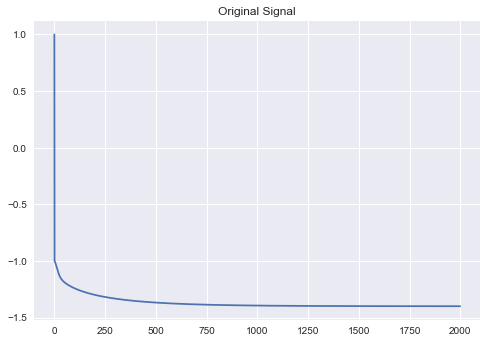

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


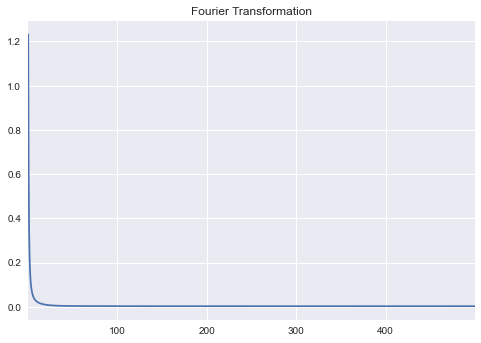

maximum PSD=(1.2316878651396874+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


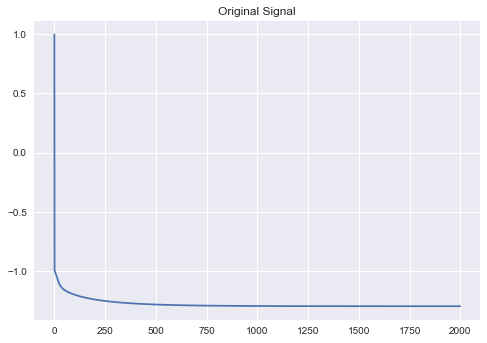

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


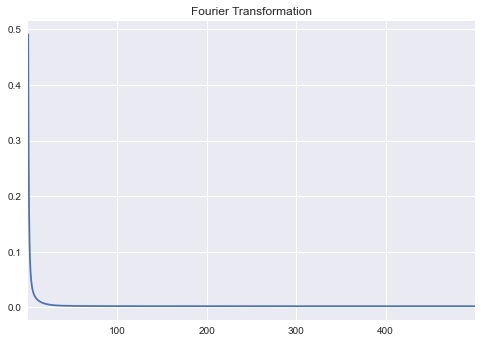

maximum PSD=(0.4906335835457993+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


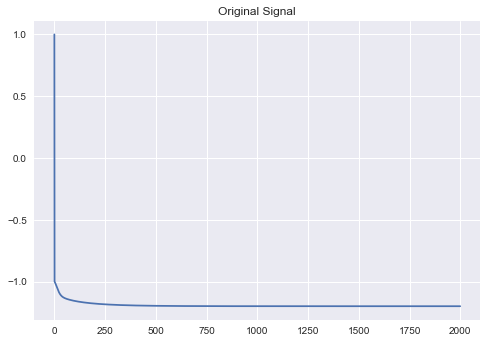

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


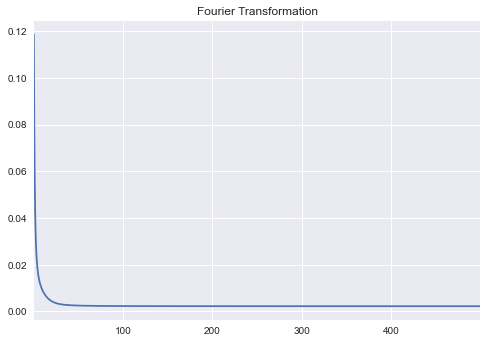

maximum PSD=(0.11860719877795786+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


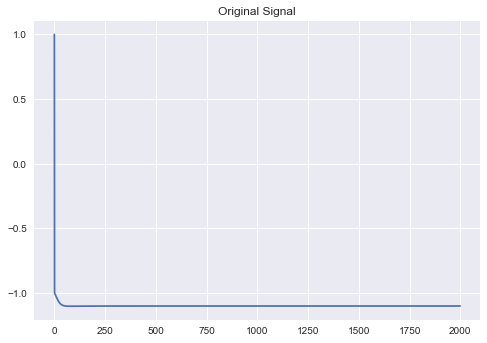

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


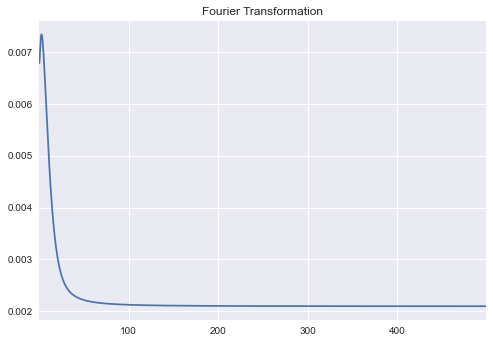

maximum PSD=(0.00733291016894605+0j)
argmax PSD=5
maximum frequency=3.001500750375187


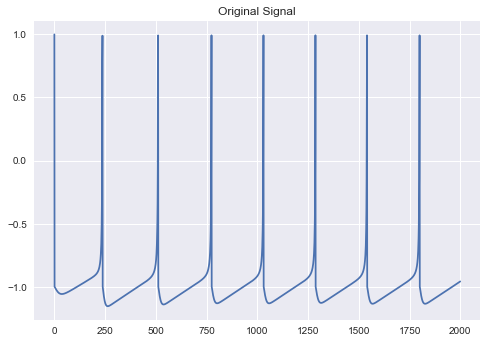

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


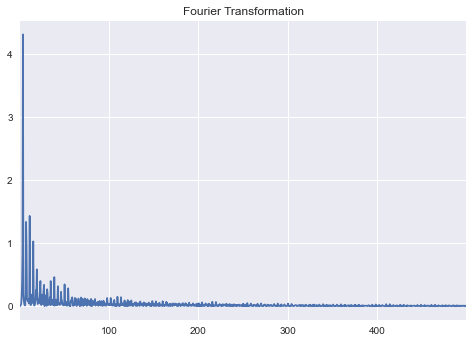

maximum PSD=(4.317864806755174+0j)
argmax PSD=7
maximum frequency=4.0020010005002495


In [49]:
sigma=-1
temp=0

while sigma<0:
    
    x_list,n=neuron_potential(sigma_list=[sigma], alpha=4)
    n-=1
    sigma+=0.1

    compute_FFT(x_list,n)

##### Continuous firing 

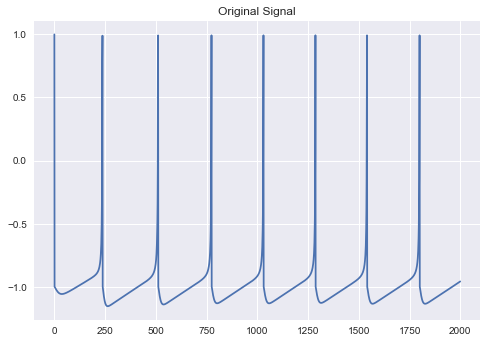

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


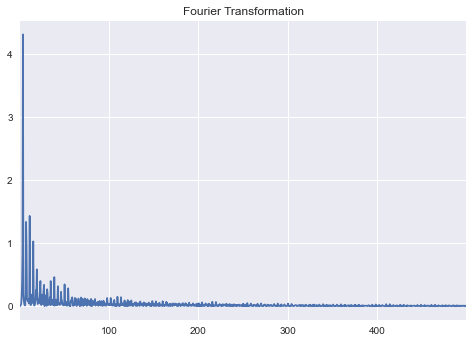

maximum PSD=(4.317864806755174+0j)
argmax PSD=7
maximum frequency=4.0020010005002495


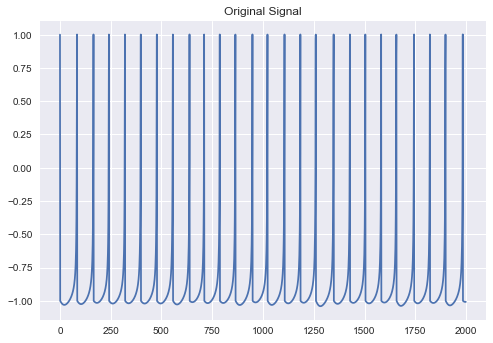

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


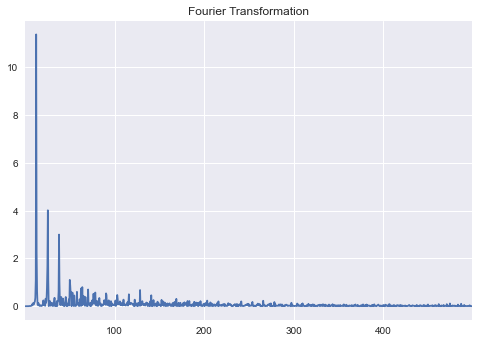

maximum PSD=(11.38526336994334+0j)
argmax PSD=24
maximum frequency=12.50625312656328


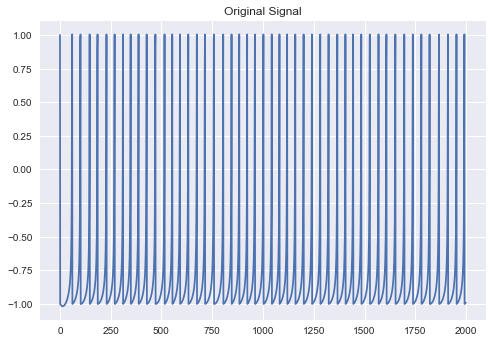

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


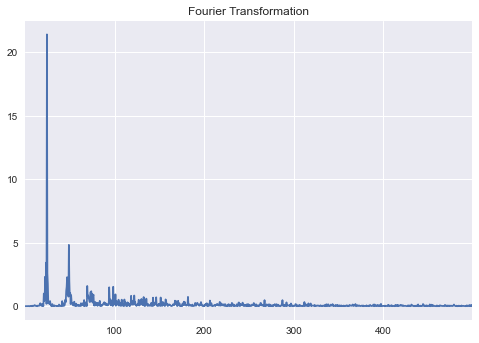

maximum PSD=(21.424520455800277+0j)
argmax PSD=48
maximum frequency=24.512256128064028


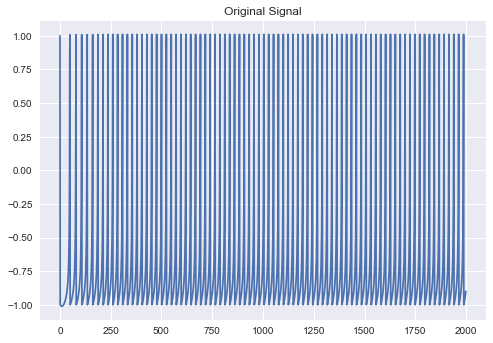

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


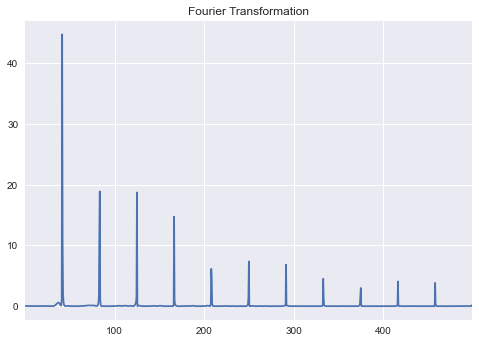

maximum PSD=(44.7176462896294+0j)
argmax PSD=82
maximum frequency=41.52076038019009


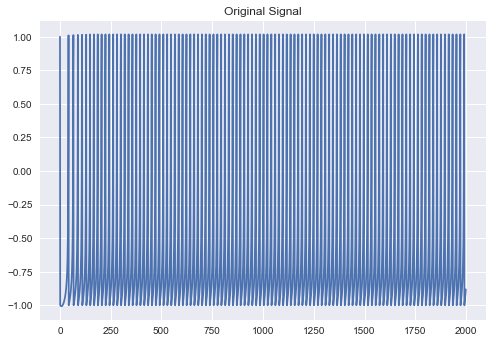

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


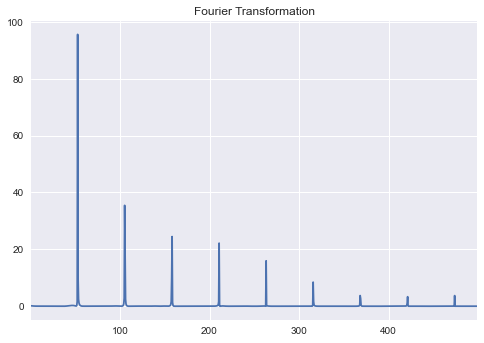

maximum PSD=(95.55911200279343+0j)
argmax PSD=104
maximum frequency=52.52626313156578


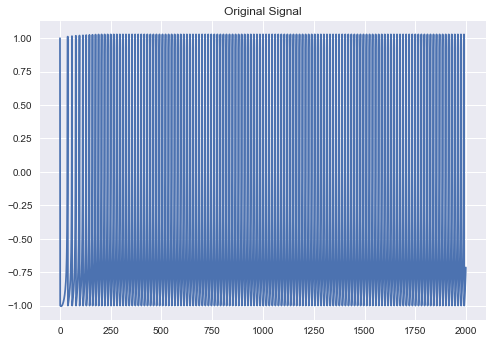

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


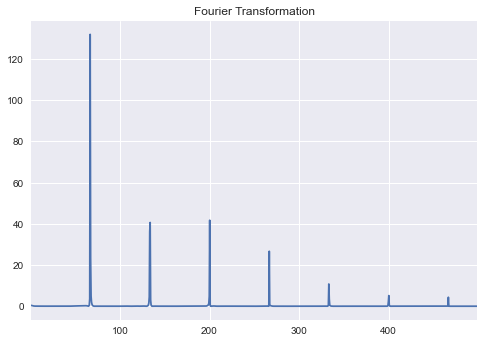

maximum PSD=(132.00593065232667+0j)
argmax PSD=132
maximum frequency=66.53326663331664


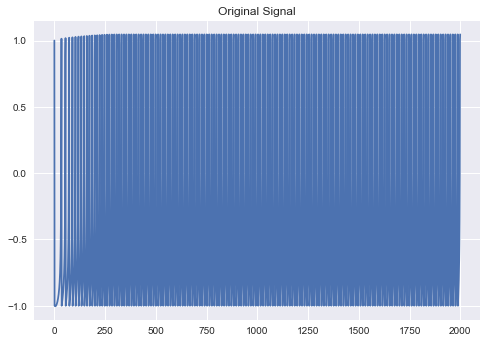

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


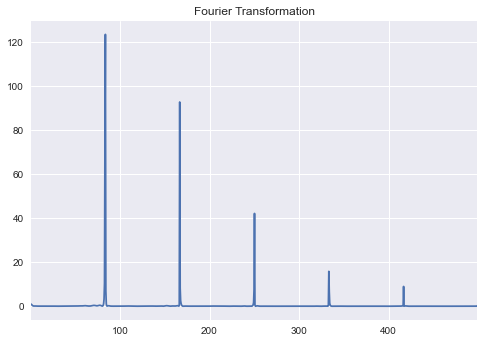

maximum PSD=(123.54634836945974+0j)
argmax PSD=166
maximum frequency=83.54177088544272


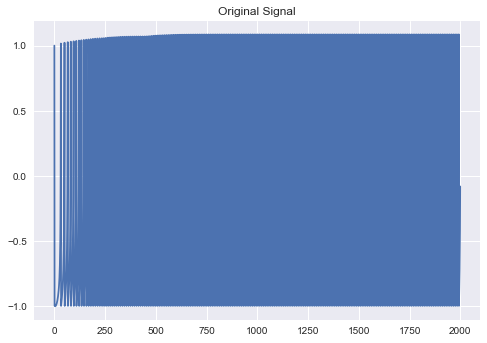

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


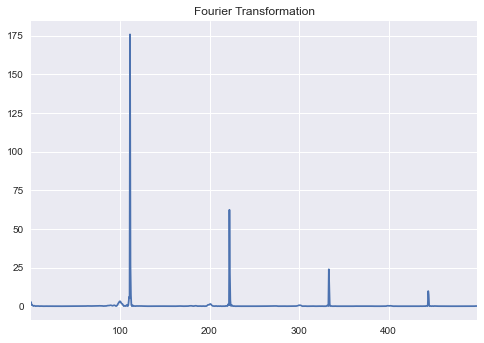

maximum PSD=(175.7741443109485+0j)
argmax PSD=221
maximum frequency=111.05552776388193


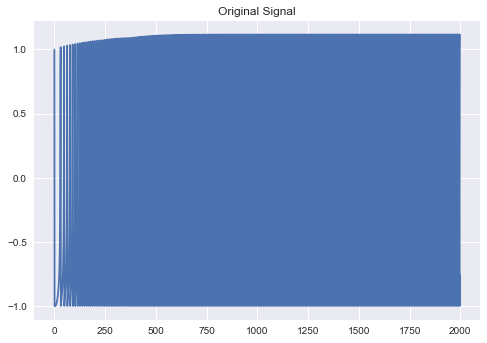

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


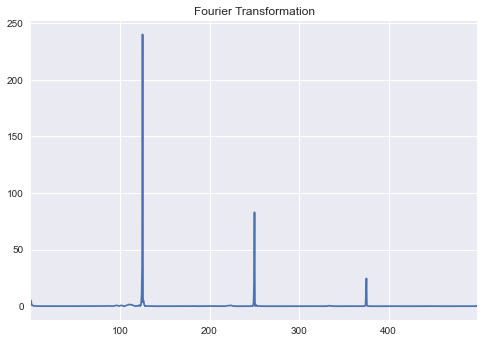

maximum PSD=(240.0063129950868+0j)
argmax PSD=249
maximum frequency=125.0625312656328


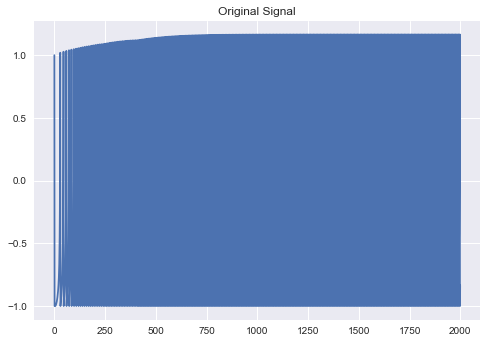

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


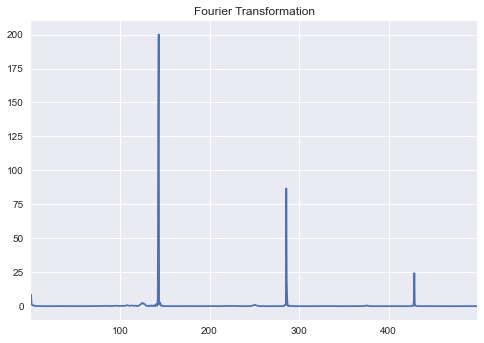

maximum PSD=(200.12134711265526+0j)
argmax PSD=285
maximum frequency=143.07153576788392


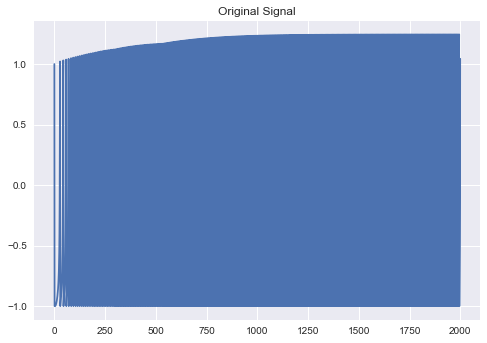

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


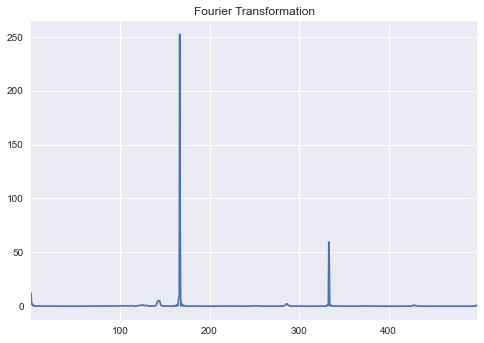

maximum PSD=(252.13765431424105+0j)
argmax PSD=332
maximum frequency=166.5832916458229


In [50]:
sigma=0
temp=0

while sigma<=1:
    
    x_list,n=neuron_potential(sigma_list=[sigma], alpha=4)
    n-=1
    sigma+=0.1
    
    compute_FFT(x_list,n)

##### Bursts of spikes  

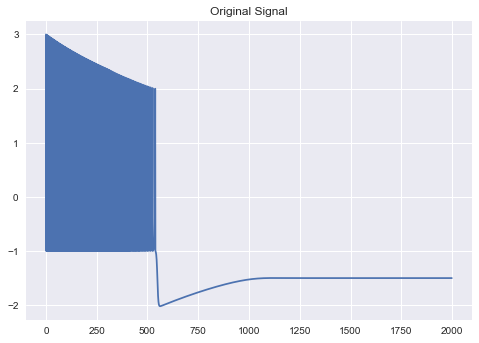

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


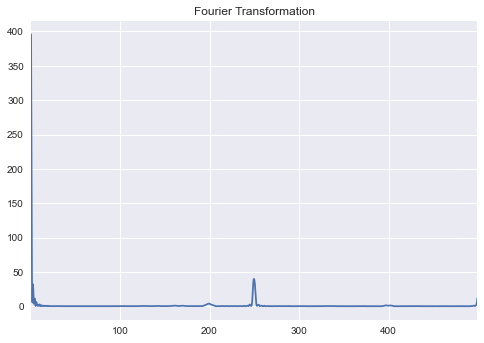

maximum PSD=(395.74823369685066+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


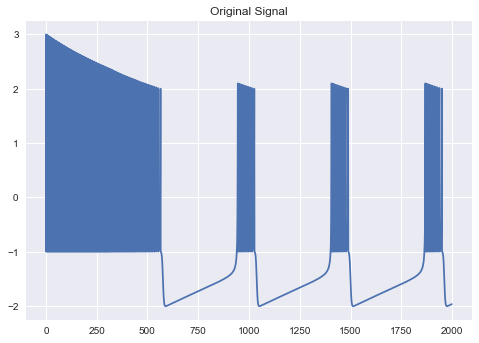

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


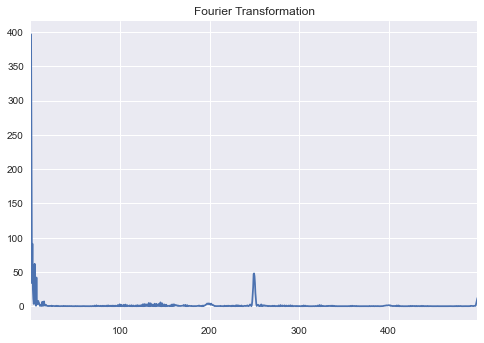

maximum PSD=(396.404135541201+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


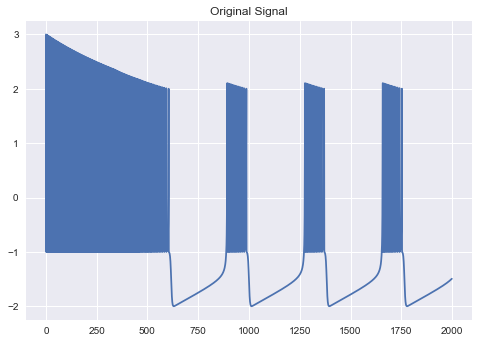

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


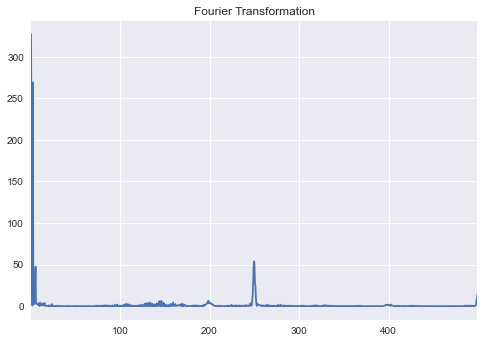

maximum PSD=(326.73227626683416+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


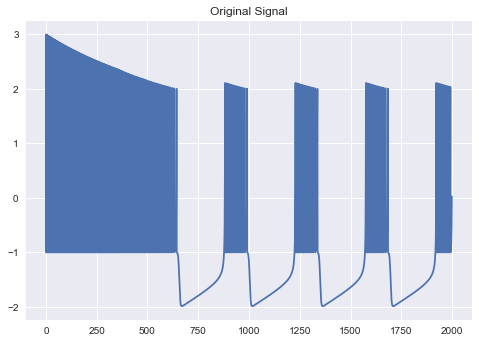

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


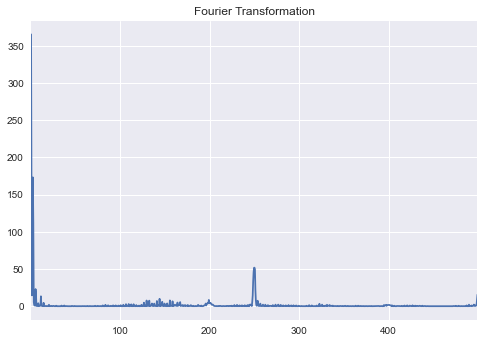

maximum PSD=(365.31257358148775+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


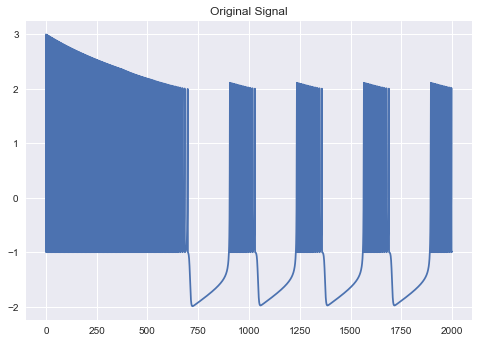

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


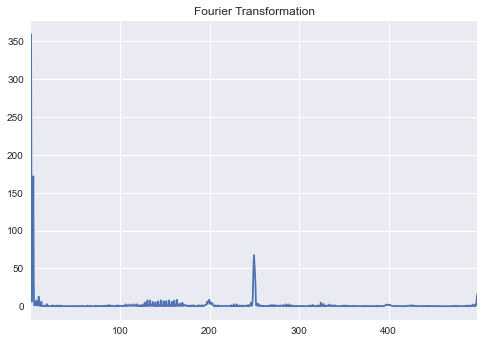

maximum PSD=(359.3317823673997+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


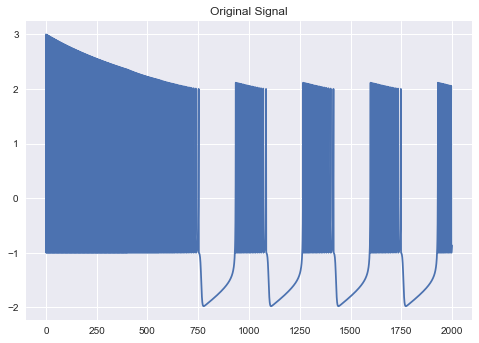

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


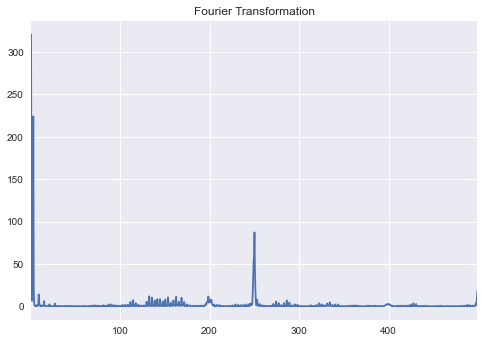

maximum PSD=(320.9009158263159+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


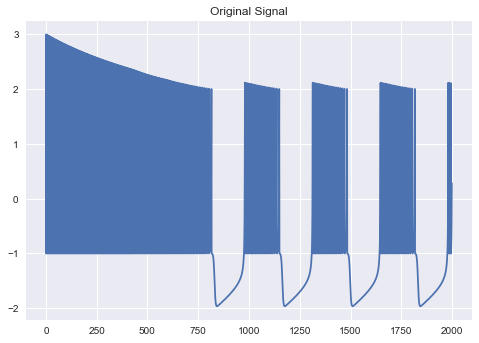

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


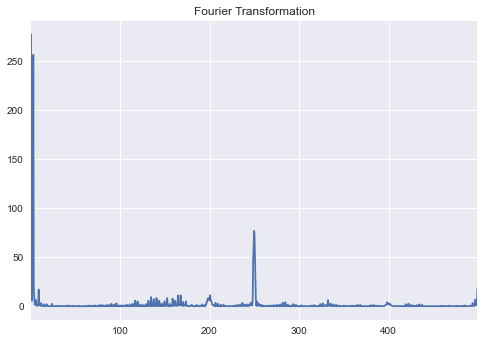

maximum PSD=(277.0580871465496+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


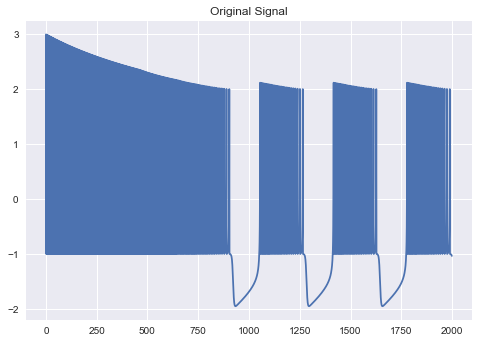

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


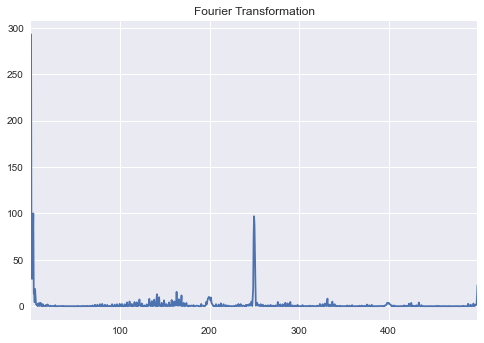

maximum PSD=(292.8998775454042+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


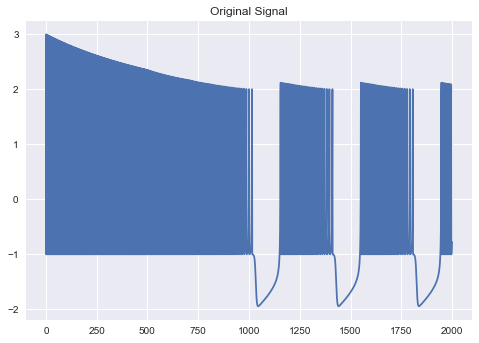

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


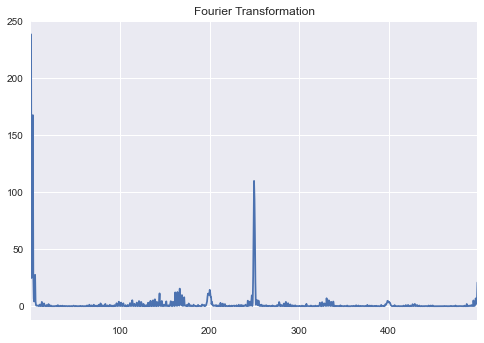

maximum PSD=(238.12038520088905+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


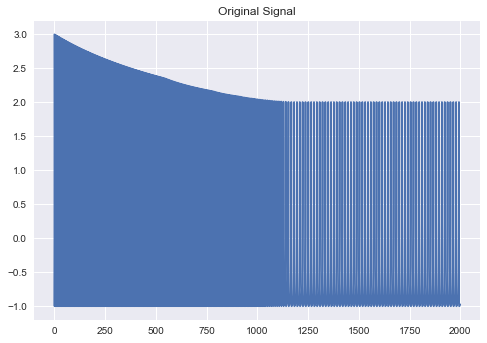

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


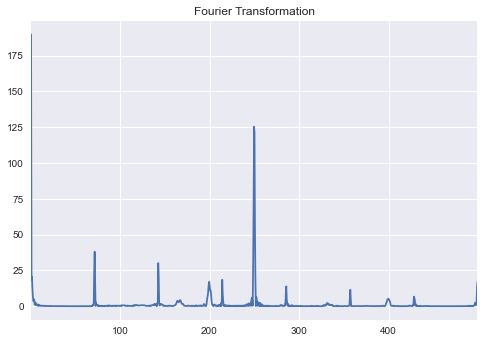

maximum PSD=(189.7581109566206+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


In [51]:
sigma=-0.5
temp=0

while sigma<0.5:
    
    x_list,n=neuron_potential(sigma_list=[sigma], alpha=6)
    n-=1
    sigma+=0.1
    
    compute_FFT(x_list,n)


##### Boundary areas

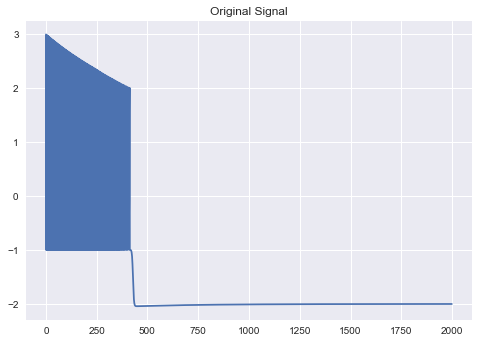

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


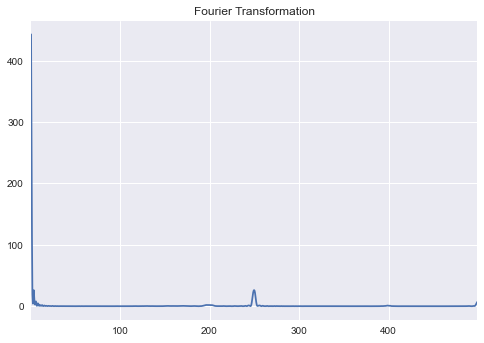

maximum PSD=(442.73404755067764+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


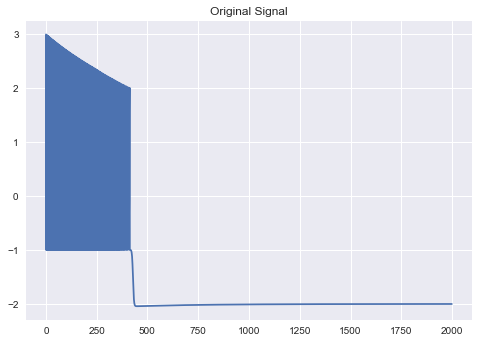

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


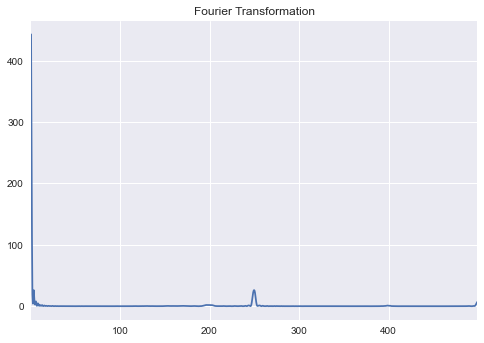

maximum PSD=(442.73404755067764+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


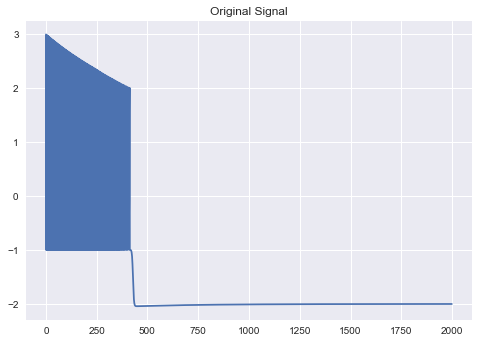

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


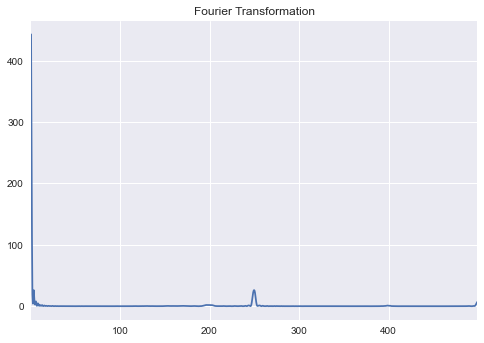

maximum PSD=(442.73404755067764+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


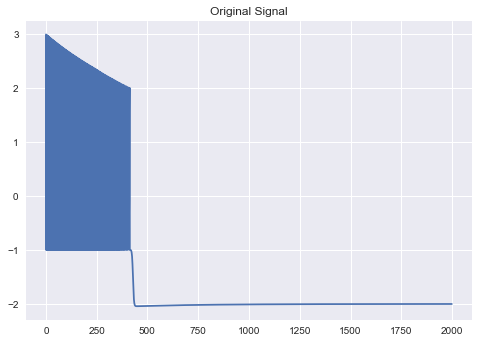

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


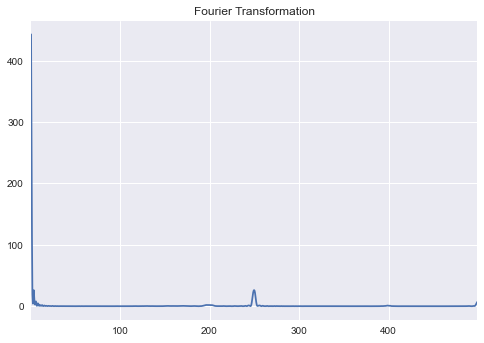

maximum PSD=(442.73404755067764+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


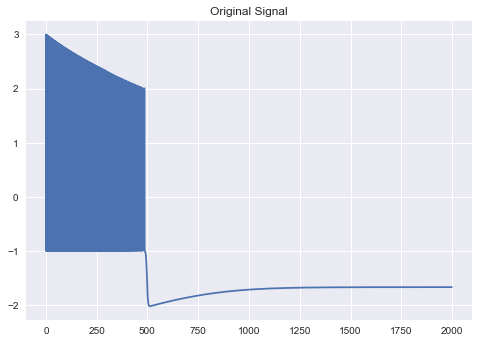

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


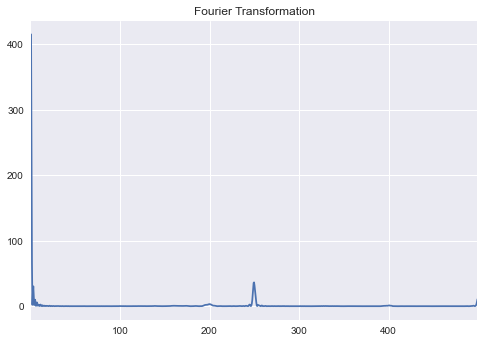

maximum PSD=(415.2610409765883+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


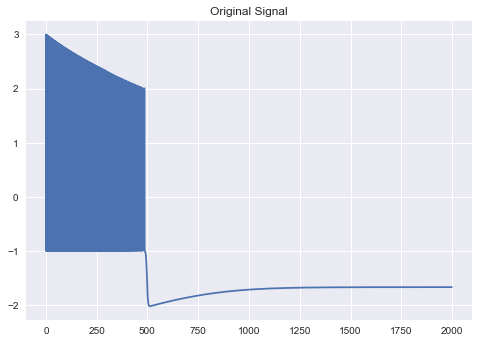

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


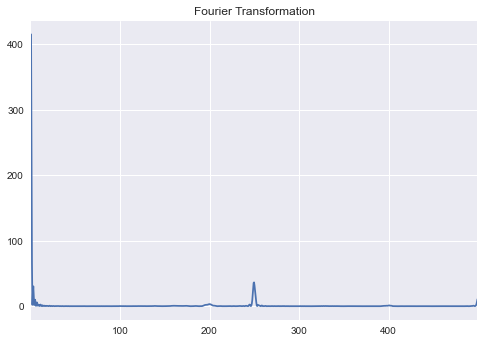

maximum PSD=(415.2610409765883+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


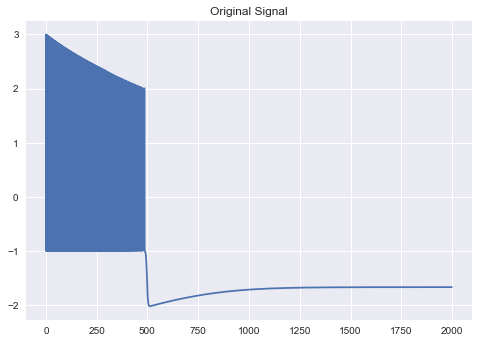

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


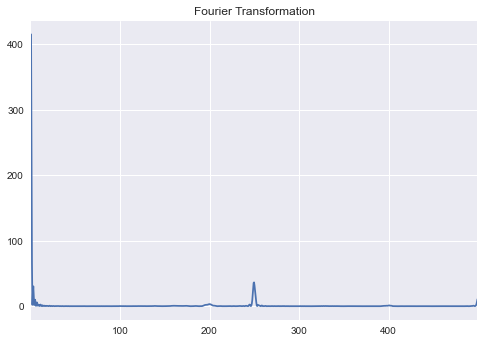

maximum PSD=(415.2610409765883+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


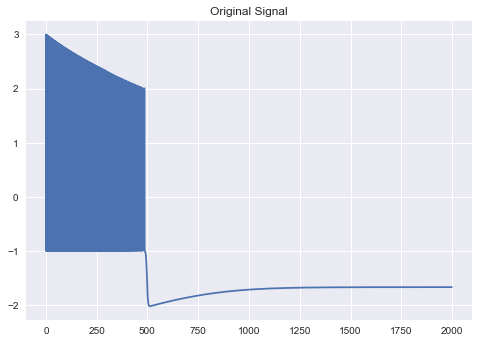

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


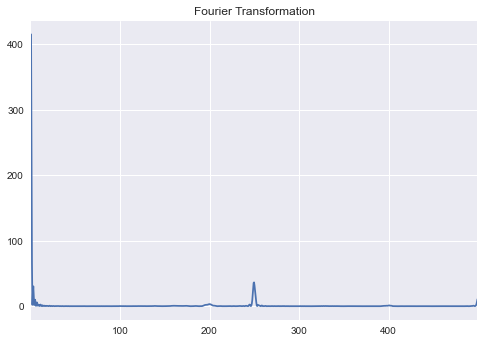

maximum PSD=(415.2610409765883+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


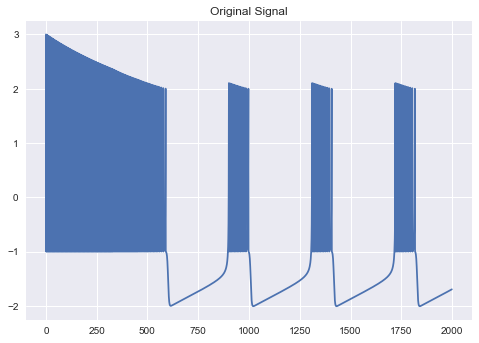

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


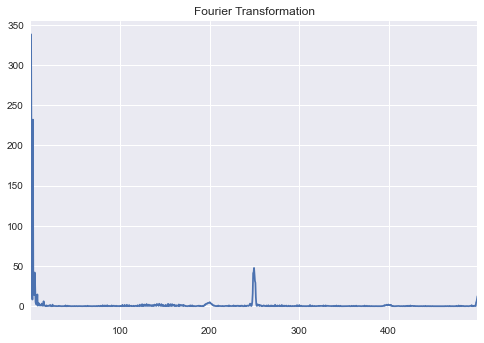

maximum PSD=(337.92049518914536+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


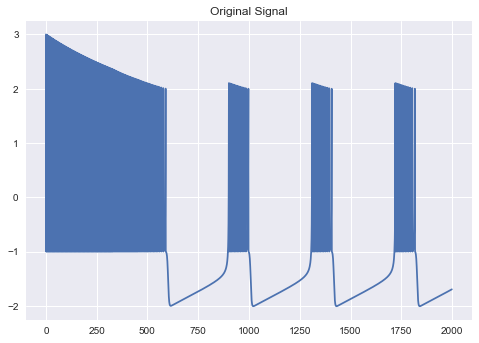

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


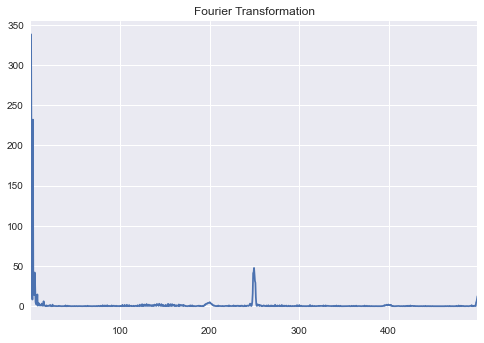

maximum PSD=(337.92049518914536+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


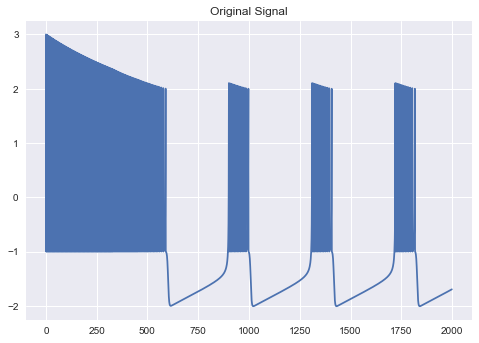

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


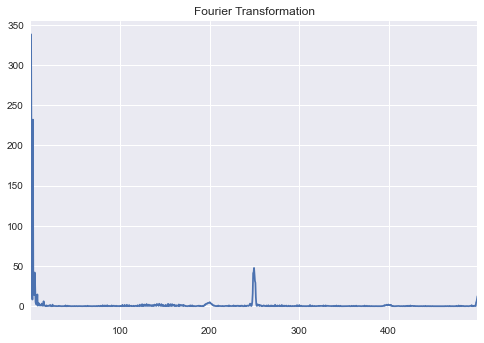

maximum PSD=(337.92049518914536+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


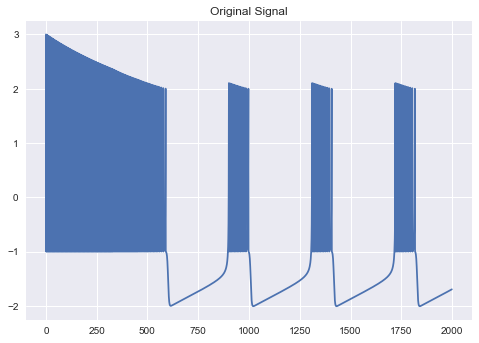

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


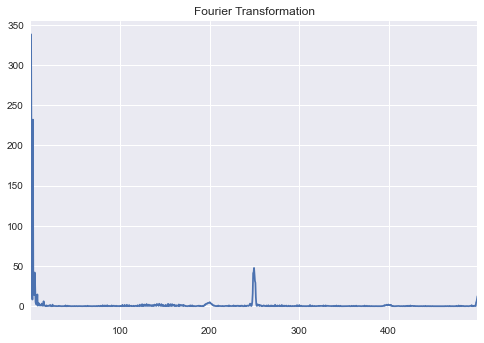

maximum PSD=(337.92049518914536+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


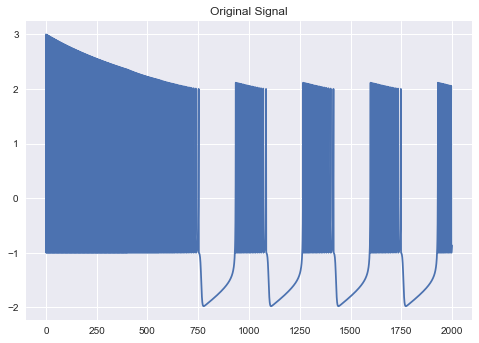

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


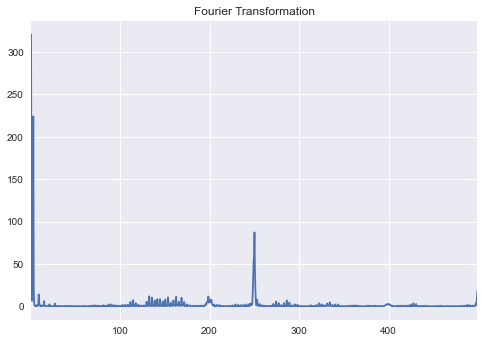

maximum PSD=(320.9009158263159+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


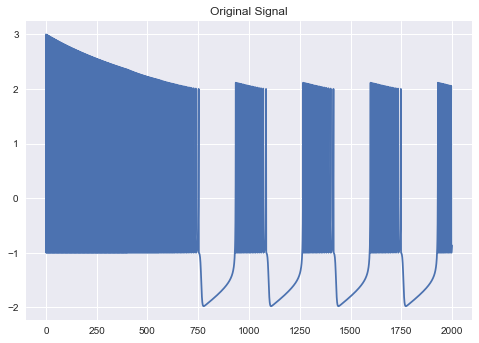

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


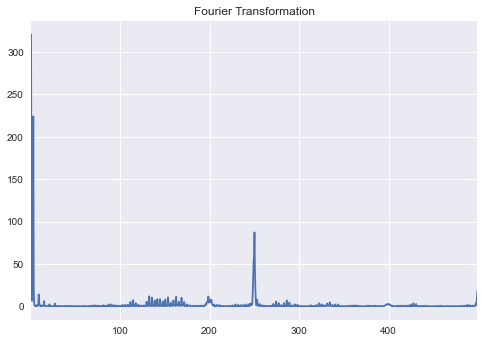

maximum PSD=(320.9009158263159+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


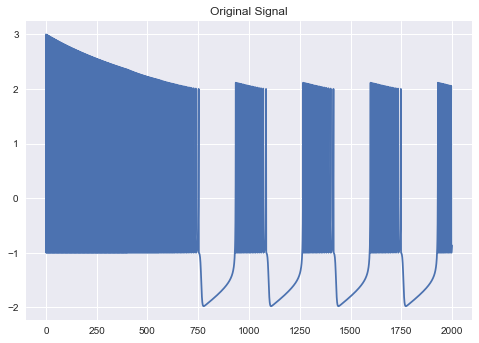

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


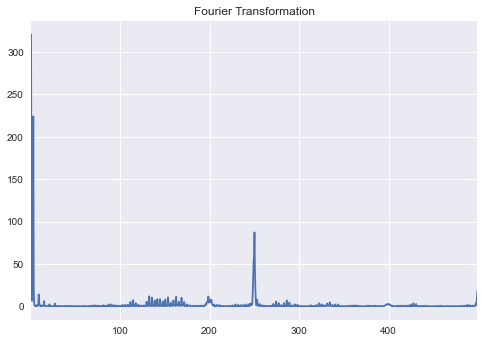

maximum PSD=(320.9009158263159+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


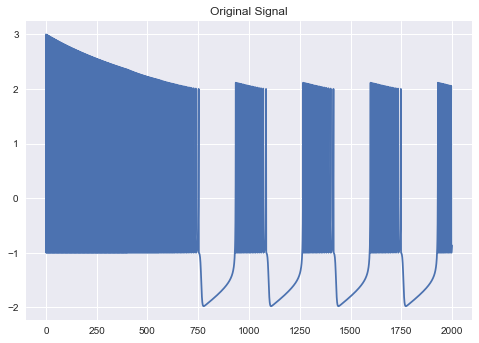

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


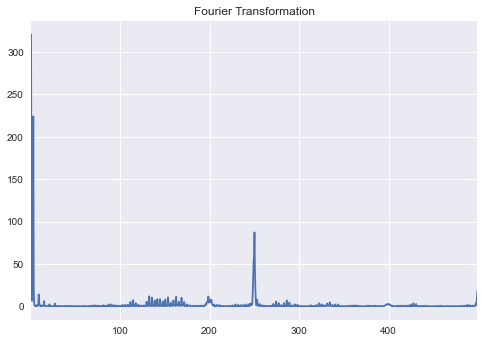

maximum PSD=(320.9009158263159+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


In [52]:
sigmas=np.linspace(-1,0,4)   
alphas=np.linspace(5,8,4)

for sigma in sigmas:
    for alpha in alphas:

        x_list,n=neuron_potential(sigma_list=[sigma], alpha=6)
        n-=1
        
        compute_FFT(x_list,n)


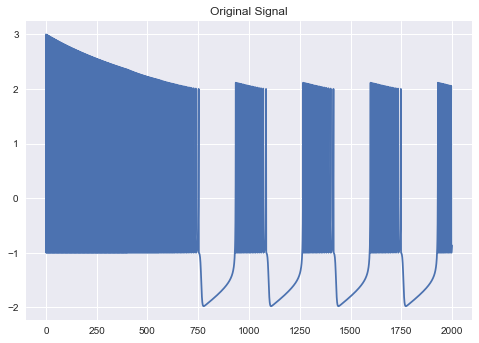

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


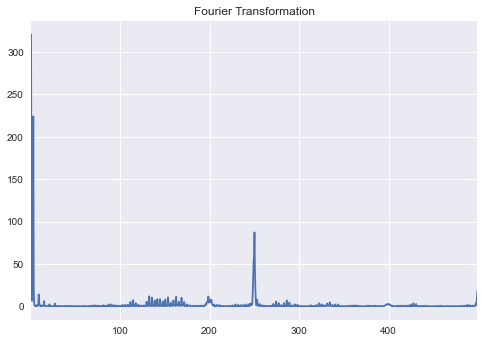

maximum PSD=(320.9009158263159+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


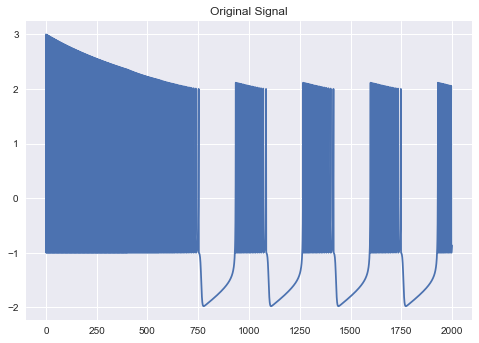

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


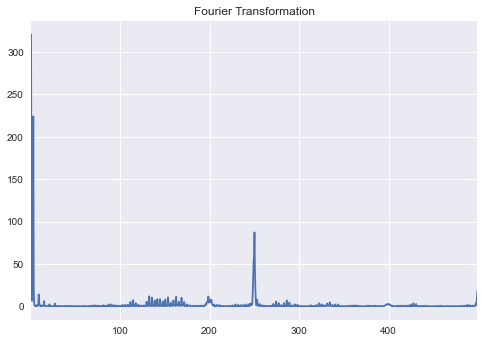

maximum PSD=(320.9009158263159+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


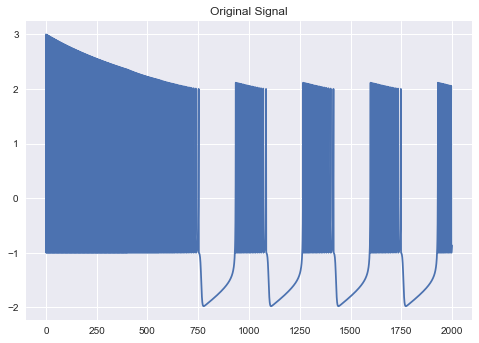

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


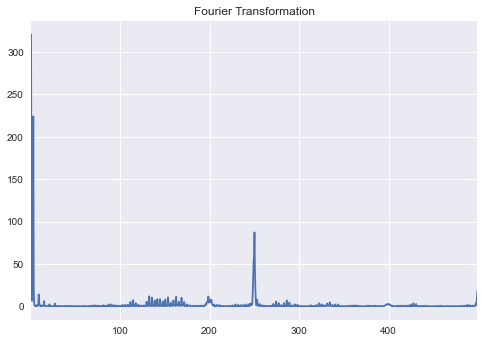

maximum PSD=(320.9009158263159+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


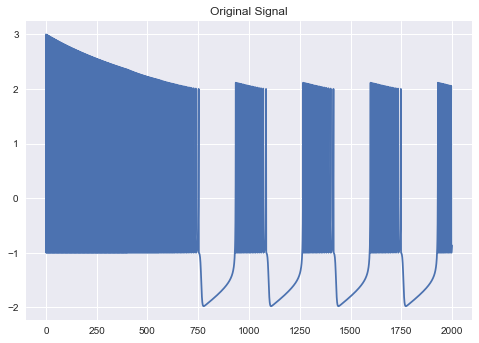

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


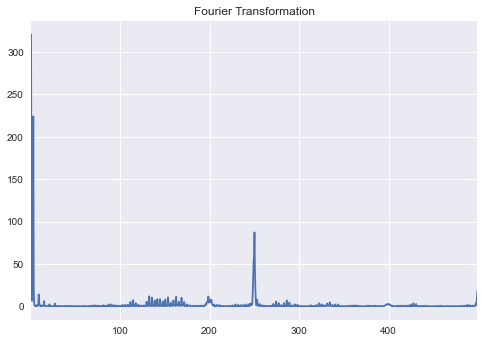

maximum PSD=(320.9009158263159+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


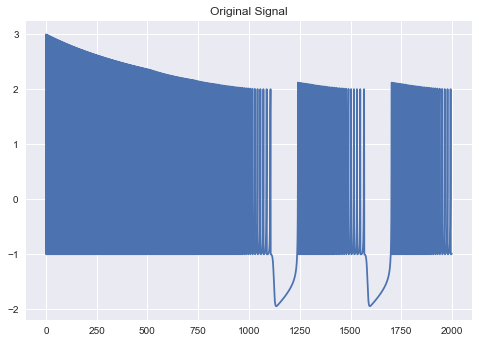

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


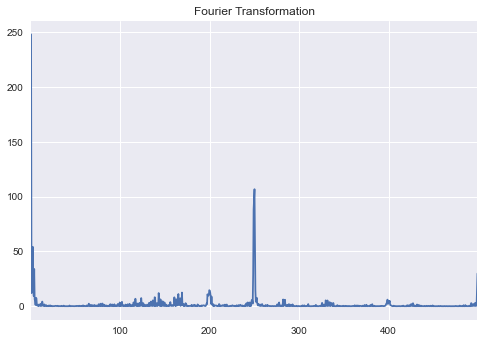

maximum PSD=(247.94971341103616+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


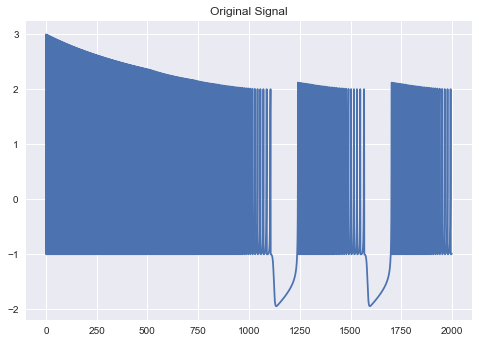

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


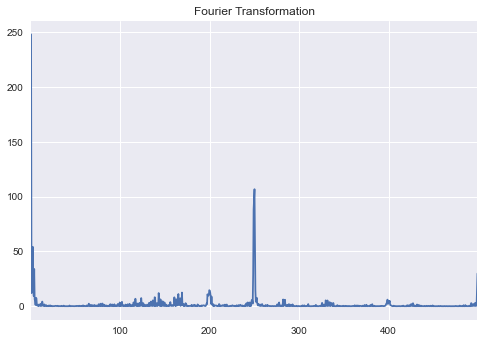

maximum PSD=(247.94971341103616+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


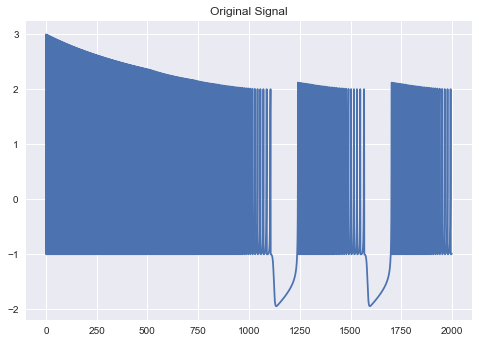

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


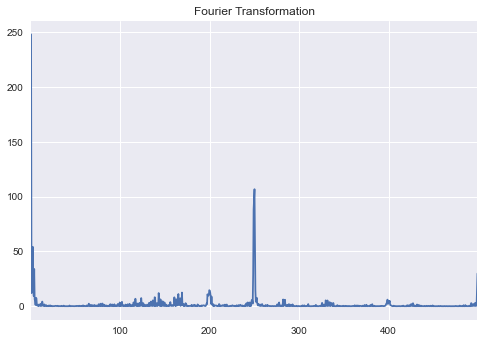

maximum PSD=(247.94971341103616+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


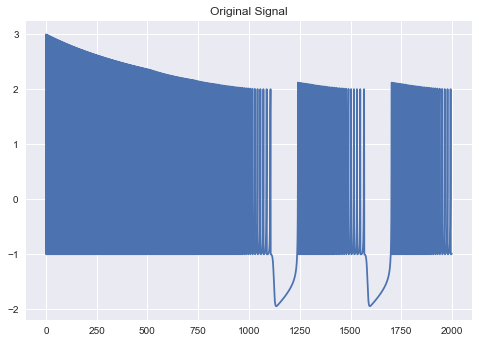

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


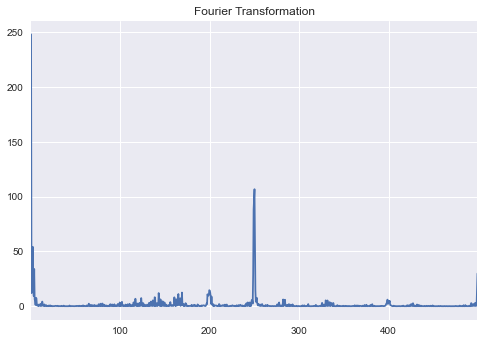

maximum PSD=(247.94971341103616+0j)
argmax PSD=0
maximum frequency=0.5002501250625312


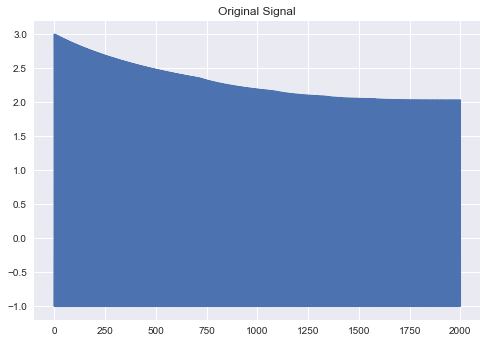

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


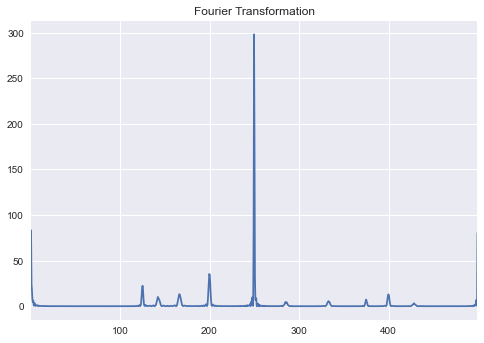

maximum PSD=(298.1690835964051+0j)
argmax PSD=498
maximum frequency=249.62481240620306


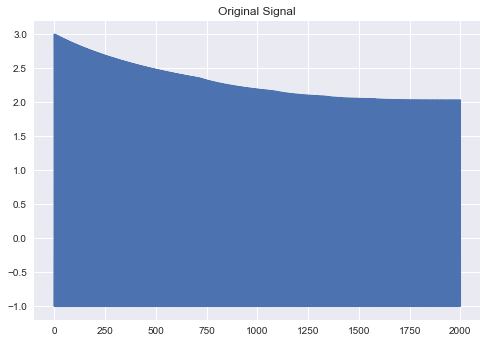

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


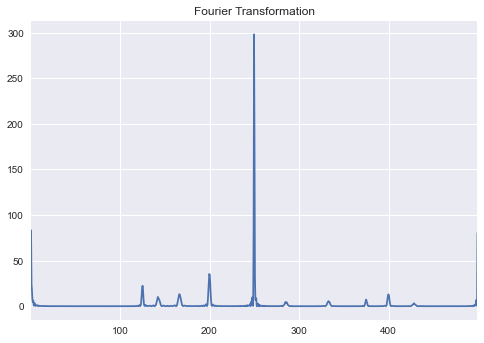

maximum PSD=(298.1690835964051+0j)
argmax PSD=498
maximum frequency=249.62481240620306


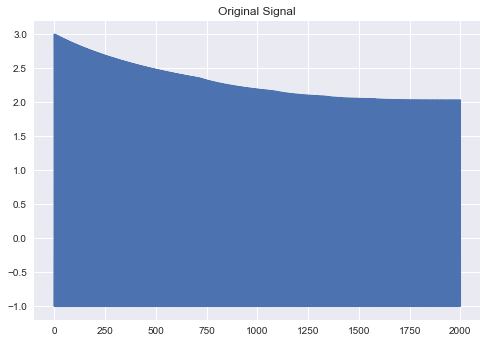

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


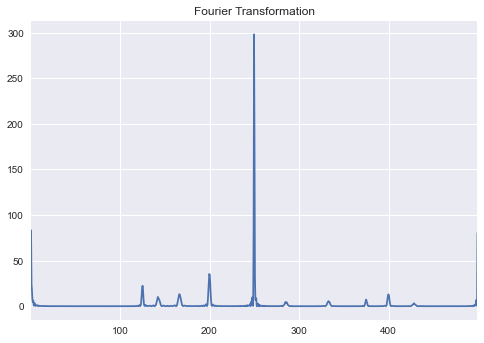

maximum PSD=(298.1690835964051+0j)
argmax PSD=498
maximum frequency=249.62481240620306


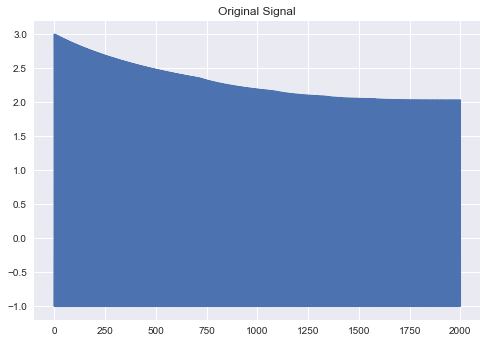

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


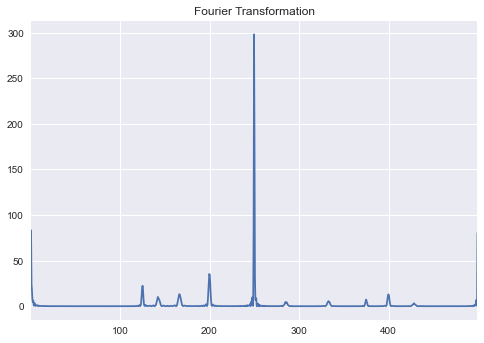

maximum PSD=(298.1690835964051+0j)
argmax PSD=498
maximum frequency=249.62481240620306


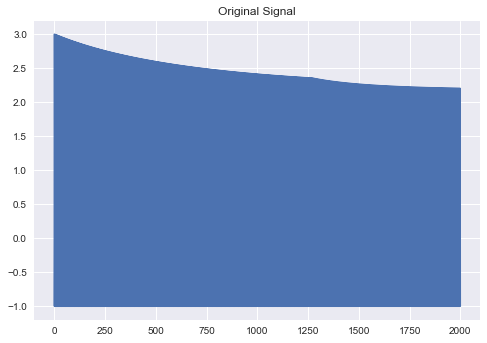

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


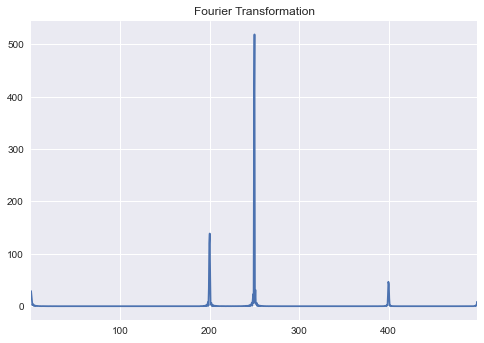

maximum PSD=(519.0650354866909+0j)
argmax PSD=499
maximum frequency=250.1250625312656


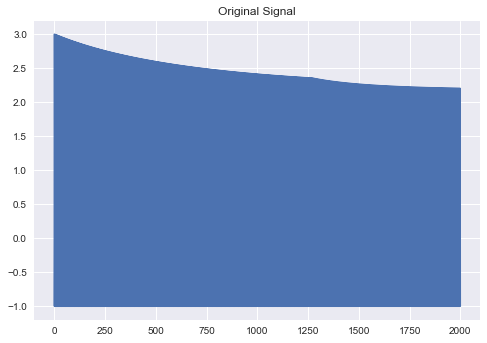

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


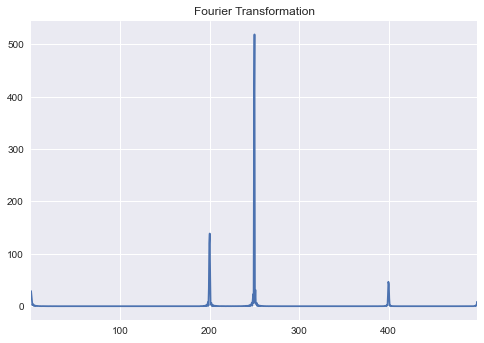

maximum PSD=(519.0650354866909+0j)
argmax PSD=499
maximum frequency=250.1250625312656


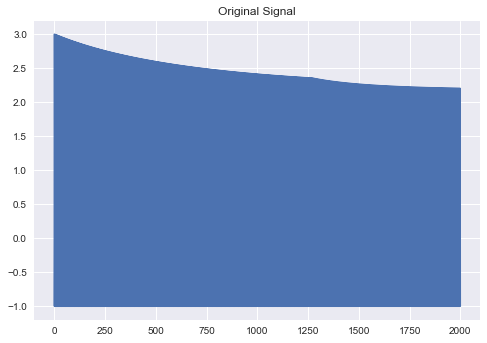

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


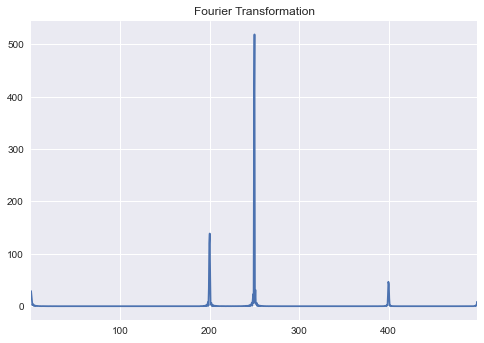

maximum PSD=(519.0650354866909+0j)
argmax PSD=499
maximum frequency=250.1250625312656


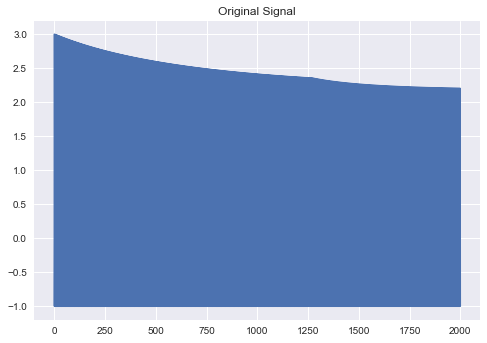

C:\Users\samru\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


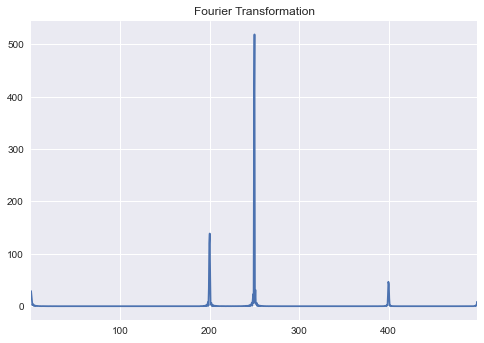

maximum PSD=(519.0650354866909+0j)
argmax PSD=499
maximum frequency=250.1250625312656


In [53]:
sigmas=np.linspace(0,1,4)   
alphas=np.linspace(2,8,4)

for sigma in sigmas:
    for alpha in alphas:

        x_list,n=neuron_potential(sigma_list=[sigma], alpha=6)
        n-=1
        
        compute_FFT(x_list,n)


#### Final classification

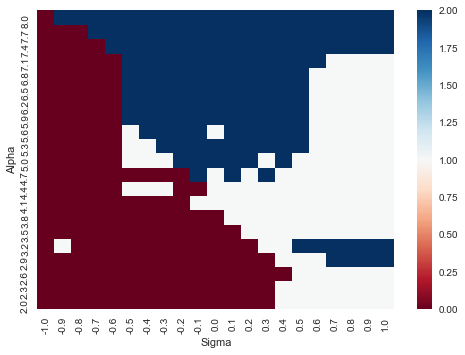

In [55]:
sigmas=np.linspace(-1,1,21)   
alphas=np.linspace(2,8,21)  
firing_type=[]
sig_list=[]
alph_list=[]

for sigma in sigmas:
    for alpha in alphas:
        sigma=round(sigma,4)
        alpha=round(alpha,4)
        

        x_list,n=neuron_potential(sigma_list=[sigma], alpha=alpha)
        n-=1

        freq,PSD,L=compute_FFT(x_list,n,return_var=True, display=False)

        arg=np.argmax(PSD[L])
        max_freq=freq[L][arg] #frequency with the maximum PSD value
        
        if max_freq<1:  
            if alpha>4 and sigma<-0.5: 
                if max(PSD[L][5:])<130: #the boundary between silent behaviour and burst firing behaviour
                    firing_type.append(0) #period of silence 
                else:
                    firing_type.append(2) #bursts of firing
            else:
                if max(PSD[L][5:])<4: #the FFT signal is generally flat for the silent neurons post the initial frequency range 
                    firing_type.append(0)
                elif 4<max(PSD[L][5:])<20: 
                    firing_type.append(1) #continuous firing
                else:
                    firing_type.append(2) #burst firing behaviour usually has higher maximum PSD values 
        elif 1<max_freq<252:   #general range of maximum frequency values for continously firing neurons
            firing_type.append(1)  
        elif max_freq>252:      #general range of maximum frequency values for neurons firing in bursts
            firing_type.append(2)  
       
            
        sig_list.append(sigma)
        alph_list.append(alpha)

df = pd.DataFrame (list(zip(sig_list, alph_list, firing_type)),
                   columns =['Sigma', 'Alpha', 'Type'])
pivotted= df.pivot('Alpha','Sigma','Type')
ax=sns.heatmap(pivotted,cmap='RdBu')
ax.invert_yaxis()

### References


BRUNTON, S., & KUTZ, N. (2019). Data-Driven Science and Engineering (1st ed.). Cambridge University Press.

Kinsley, H. (2021). Python Programming Tutorials. Retrieved 29 March 2021, from https://pythonprogramming.net/q-learning-reinforcement-learning-python-tutorial/

Kinsley, H., & Kukieła, D. (2020). Neural Networks from Scratch in Python.

Q-Learning Explained - A Reinforcement Learning Technique. (2021). Retrieved 29 March 2021, from https://deeplizard.com/learn/video/qhRNvCVVJaA

Rulkov, N. (2002). Modeling of spiking-bursting neural behavior using two-dimensional map. Physical Review E, 65(4). doi: 10.1103/physreve.65.041922